In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing
import GPy
import itertools
%matplotlib inline
import math
from sklearn.datasets import fetch_mldata
from pandas.tools.plotting import autocorrelation_plot

In [14]:
class data(object):
    #first functional and 1-d structures
    raw_data = None
    struct_data = None
    all_train = None
    all_test = None
    
    #will keep the augmented stuff separate this is functional aug
    aug_raw_data = None
    aug_struct_data = None
    all_aug_train = None
    all_aug_test = None
    samp_aug_train = None
    samp_aug_test = None
    
    #for the ou seasonality
    seasonal = None
    
    def __init__(self, seed, name, years, days, ob_year, ob_day, reset, add_seas, laplace, sigma):
        self.seed = seed
        self.name = name
        self.years = years
        self.days = days
        self.ob_year = ob_year
        self.ob_day = ob_day
        self.reset = reset
        
        #for OU process
        self.mu= 0.0 #still looking at ou cal v GP
        self.theta=0.008
        self.sigma= sigma #1.2#0.1#0.01 #0.4
        
        #fix for the simulations
        self.sim_adjustment_val = 0
        self.add_seas = add_seas
        self.laplace = laplace
        self.get_raw_data()
    
    def get_raw_data(self):
        n = list(range(1,self.years+1))
        ob = list(range(1,self.days+1))
        c = list(itertools.product(n, ob))
        
        flat_combo = [[elem[0],elem[1]] for elem in c]
        self.raw_data = pd.DataFrame(flat_combo, columns=['Year', 'Day'])   
        self.raw_data['Ones']=1
        self.raw_data['Day_Index'] = self.raw_data['Ones'].cumsum()
        self.raw_data.drop('Ones', axis=1, inplace=True)  
    
        self.raw_data['TPrices'] = self.OU(self.mu, self.theta, self.sigma)
        self.raw_data['NoiselessPrice'] = self.raw_data['TPrices']
        self.raw_data['OPrice']= self.raw_data['TPrices'].shift(1)
        self.raw_data['OPrice'][0]= self.raw_data['OPrice'][1]
        
    
    def get_aug_raw_data(self):
        n=list(range(1,self.years+1))
        ob=list(range(1,self.days+1))
        c = list(itertools.product(n, ob))
        tar=list(range(1,self.days+1))
        combo = list(itertools.product(c,tar))
        flat_combo = [[elem[0][0],elem[0][1],elem[1]] for elem in combo]

        self.aug_raw_data = pd.DataFrame(flat_combo, columns=['Year', 'Ob_day', 'Tar_day',])
        self.aug_raw_data['Delta']= self.aug_raw_data['Tar_day'] - self.aug_raw_data['Ob_day']

        prices = self.OU(self.mu, self.theta, self.sigma)
        
        pd_func = pd.DataFrame(prices)
        repeat_stock_num = int(self.aug_raw_data.shape[0]/ pd_func.shape[0])
        
        
        #needs tidying but here I am creating a signal feature for augmented
        df = pd_func.copy()
        df['OPrice'] = pd_func.shift(1)

        df['Up'] = df['OPrice']>df['OPrice'].shift(1)
        df['Plus'] = (df['OPrice']<3.2)&(df['Up']==True)
        df['Minus'] = (df['OPrice']>-3.2)&(df['Up']==False)
        df['Flat'] = (df['Minus']==False) &(df['Plus']==False)
        df['S1']=0
        df['S2']=0
        df['S3']=0

        df.loc[df['Plus']==True,'S1']=1
        df.loc[df['Minus']==True,'S2']=1
        df.loc[df['Flat']==True,'S3']=1

        df.drop(['Up','Plus','Minus','Flat'],axis=1, inplace=True)
        #print(df)
        
        #ob price
        lastprice = list(pd_func.shift(1).values)
        lastprice[0]=lastprice[1] #for now just copy the first price
        lastprice = np.array(lastprice*repeat_stock_num).reshape(self.days,-1).T
        self.aug_raw_data['OPrice'] = lastprice.reshape(-1)
        
        #Signal
        raw_signal = list(df['S1'].values)
        signal = np.array(raw_signal*repeat_stock_num).reshape(self.days,-1).T
        self.aug_raw_data['S1'] = signal.reshape(-1)
        
        raw_signal = list(df['S2'].values)
        signal = np.array(raw_signal*repeat_stock_num).reshape(self.days,-1).T
        self.aug_raw_data['S2'] = signal.reshape(-1)
        
        raw_signal = list(df['S3'].values)
        signal = np.array(raw_signal*repeat_stock_num).reshape(self.days,-1).T
        self.aug_raw_data['S3'] = signal.reshape(-1)
        
        
        #trpice
        self.aug_raw_data['TPrices'] = np.tile(prices.reshape(self.years,self.days),self.days).reshape((-1,))
                                                                                                                     
        #ditch values where we look back in time
        self.aug_raw_data = self.aug_raw_data[self.aug_raw_data["Delta"] >= 0]
        self.aug_raw_data = self.aug_raw_data.reset_index(drop=True)
                
    def mk_tr_tst(self):
        #create test set and train set as well as being able to preprocess
        self.struct_data = self.raw_data.copy()

        #create copies of yes/ ob day and tar day in order to preprocess some and easily be able to refer to days
        self.struct_data['Year_copy']= self.struct_data['Year']
        self.struct_data['Day_copy']= self.struct_data['Day']

        #how much training data 
        train_days = self.ob_year*self.days+self.ob_day
        all_train_data = self.struct_data[:train_days] 

        #fit our scaling on all our training data, we will apply the same to test
        #std_scale = preprocessing.StandardScaler().fit(all_train_data)
        #std_scale_TP = preprocessing.StandardScaler().fit(all_train_data['TPrices'])

        #now transform all our data on the train data scaling keep last two columns so i can still index
        #all_scaled_data = self.struct_data #std_scale.transform(self.struct_data)
        #self.struct_data[self.struct_data.columns[:-2]]=all_scaled_data[:,:-2]

        firstprice_bool = (self.struct_data['Day_copy']==1) 
        firstprices = list(self.struct_data[firstprice_bool]['TPrices'])
        
        #reset prices to zero each year a la chapados if this option is chosen
        if self.reset:
            for i in range(1,self.years+1):
                row_index =  self.struct_data['Year_copy']==i
                self.struct_data.loc[row_index, 'TPrices'] -= firstprices[i-1]

        self.all_train = self.struct_data[:train_days]

        #just test on everything for now 
        bool_test = (self.struct_data['Year_copy']>=0) & (self.struct_data['Year_copy']<self.ob_year+2)
        self.all_test = self.struct_data[bool_test]  

        #for outside experiments I will need to scale the data in the same way
        #return std_scale_TP
    
    def mk_aug_tr_tst(self, max_delta):
        #create test set and train set as well as being able to preprocess
        self.aug_struct_data = self.aug_raw_data.copy()

        #create copies of yes/ ob day and tar day in order to preprocess some and easily be able to refer to days
        self.aug_struct_data['Year_copy']= self.aug_struct_data['Year']
        self.aug_struct_data['Ob_day_copy']= self.aug_struct_data['Ob_day']
        self.aug_struct_data['Tar_day_copy']= self.aug_struct_data['Tar_day']
        self.aug_struct_data['Delta_copy']= self.aug_struct_data['Delta'] 

        #the train and test should overlap over the last data point - take this off when I am sure it is working
        tr_data_bool = (~((self.aug_struct_data['Year']>=self.ob_year+1) | (self.aug_struct_data['Delta']>max_delta))
                           |((self.aug_struct_data['Year']==self.ob_year+1) & (self.aug_struct_data['Delta']<max_delta) 
                            & (self.aug_struct_data['Ob_day']+self.aug_struct_data['Delta']<=self.ob_day)))

        self.all_aug_train = self.aug_struct_data[tr_data_bool]

        #fit our scaling on all our training data, we will apply the same to test
        #std_scale = preprocessing.StandardScaler().fit(self.all_aug_train)
        #std_scale_TP = preprocessing.StandardScaler().fit(self.all_aug_train['TPrices'])

        #transform our training data, but leave the last 4 copy columns which we use for checks and indexing
        #scaled_train_data = self.all_aug_train#std_scale.transform(self.all_aug_train)
        #self.all_aug_train[self.all_aug_train.columns[:-4]]=scaled_train_data[:,:-4]
        
        """
        ###examine scaling and inverse scaling as well as setting each years prices to begin with 0
        firstprice_bool = (all_train_data['Ob_day_copy']==1) & (all_train_data['Delta_copy']==0)
        all_train_data[all_train_data['Year_copy']==1]

        firstprices = list(all_train_data[firstprice_bool]['TPrices'])

        all_train_data_test = all_train_data

        #10 years
        num_years = 10
        for i in range(1,num_years+1):
            row_index =  all_train_data['Year_copy']==i
            all_train_data.loc[row_index, 'TPrices'] -= firstprices[i-1]

        all_train_data.head()
        """
        
        #do the same for the test data again hard coded right now
        tst_data_bool = ((self.aug_struct_data['Year']==self.ob_year+1)  & (self.aug_struct_data['Ob_day']==self.ob_day)
                        & (self.aug_struct_data['Delta']>0))
        self.all_aug_test= self.aug_struct_data[tst_data_bool]
        
        #scaled_test_data = self.all_aug_test#std_scale.transform(self.all_aug_test)
        #self.all_aug_test[self.all_aug_test.columns[:-4]]=scaled_test_data[:,:-4]
        
        #return std_scale_TP
        
    def sample(self,num_samples):
    
        #add on all delta zeros after
        sample_bool = ((self.all_aug_train['Ob_day_copy'])!=(self.all_aug_train['Tar_day_copy']))

        train_data = self.all_aug_train[sample_bool].reset_index(drop=True)

        #sampling function
        rows = np.random.choice(train_data.shape[0], num_samples, replace=False)
        rows = np.sort(rows)

        sampled_train = train_data.ix[rows]
        df_XYtrain = pd.DataFrame(sampled_train) 
        delta_zero = self.all_aug_train[(self.all_aug_train['Delta_copy']==0)]
        #how we sample seems important - go out to max delta...not including all delta zeros
        #but from the beginning of that year
        #print(delta_zero[delta_zero['Year_copy']==10])
        self.samp_aug_train = pd.concat([df_XYtrain, delta_zero[self.ob_year*self.days:]], axis=0)
        #self.samp_aug_train = df_XYtrain
    
        self.samp_aug_test = pd.concat([delta_zero, self.all_aug_test], axis=0)
        
    def plot_auto(self, filename=None):
        autocorrelation_plot(self.struct_data['TPrices'])
        if filename:
            #plt.savefig('./figs/'+filename)
            plt.show()
            
    def plot(self, filename="stock"):
        if self.name == "ou":
            plt.title("OU process")
            plt.ylabel("Price")
            plt.plot(self.struct_data['TPrices'],'-b')
            #plt.savefig('./figs/ou.png')
            plt.show()
    
    def plot_curves(self,filename="functional"):
        #Now look at the functional version
        X_train = self.all_train
        for i in range(1,self.years+1):
            prices = X_train[X_train['Year_copy']==i]['TPrices']
            day  = X_train[X_train['Year_copy']==i]['Day_copy']
            ymin, ymax = plt.ylim()
            plt.vlines(self.ob_day,ymin,ymax)
            plt.plot(day, prices)
        #plt.savefig('./figs/'+filename)
     
    def OU(self, mu, theta, sigma):
        #The above discretisation is only valid for very small dt
        # Gillespie 1996, See also “Monte Carlo Simulation of Stochastic Processes”
    
        np.random.seed(self.seed)
        t_0 = 1      # define model parameter
        t_end = self.years*self.days
        length = self.years*self.days

        t = np.linspace(t_0,t_end,length)  # define time axis
        dt = np.mean(np.diff(t))

        y_gill = np.zeros(length)
        y_gill[0] = 0 #use a fixed starting point#np.random.normal(loc=0.0,scale=1.0)

        drift = lambda y,t: theta*(mu-y)      # define drift term
        diffusion = lambda y,t: sigma# define diffusion term
        noise = np.random.normal(loc=0.0,scale=1.0,size=length)*np.sqrt(dt) #define noise process
        
        #laplace = True
        #fat tails laplace noise
        if laplace:
            #noise = np.random.laplace(loc=0.0,scale=1.0,size=length)*np.sqrt(dt)
            #change this as we are going to test by varying the t degrees of freedom
            noise = np.random.standard_t(15, size=length)*np.sqrt(dt)
            
        # solve SDE
        for i in range(1,length):
            y_gill[i] = np.exp(-theta*dt)*y_gill[i-1] + (1- np.exp(-theta*dt))*mu  \
                                              + sigma*noise[i]* np.sqrt((1-np.exp(-2*theta*dt)/2*theta))
        #add more structure
        #note one subtlety if i am adding ou noise i currently want it unrelated to the function i add to
        #when simulating going forward from a certain level we simulate from the level of the function and
        #the noise together - so simulate taking off the level of the function at that point and then add
        #that noise to the function - unfortunately this hadn't been designed from the start and the value
        #we need to take off is hidden in here...lets call it sim_adjustment_val
        
        #add_seas = True
        if add_seas:
            
            #seasonal = np.tile(np.sin(np.linspace(1,250,250)*2*math.pi/250)*4,10)
            seasonal = np.tile(np.sin(np.linspace(1,length/10,length/10)*2*math.pi/(length/10))*4,10)
            self.seasonal = seasonal #-np.mean(seasonal)
            
            #adjustment value so the OU mean reverts according to its vol level, not seasonal too
            self.sim_adjustment_val = self.seasonal[self.days*self.ob_year+self.ob_day]
            return(y_gill+seasonal)
        else:
            return(y_gill)
    
    

In [15]:
class opt(object):
    X=None
    y=None
    Xpred=None
    ytest=None
    ll=None
    var=None
    mod=None
    
    def __init__(self, train_data, test_data, feat_lst, years, days, obs_year, obs_day):
        self.train_data = train_data
        self.test_data = test_data
        self.feat_lst = feat_lst
        self.years = years
        self.days = days
        self.obs_year = obs_year
        self.obs_day = obs_day
        self.prep4opt()
    
    def prep4opt(self):
        self.X = (self.train_data[self.feat_lst].as_matrix())
        self.y = ((self.train_data[['TPrices']]).as_matrix())

        self.Xpred = (self.test_data[self.feat_lst].as_matrix())
        self.ytest = ((self.test_data[['TPrices']]).as_matrix())

    
    def run_opt(self,kern,restarts, aug=False):    
        k_input_d = self.X.shape[1]
        
        if not aug:
            if kern == "rat":
                k = GPy.kern.RatQuad(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)
            elif kern == "mat":
                k = GPy.kern.Matern32(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)
            elif kern == "ou":
                k = GPy.kern.OU(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)
            elif kern == "rbf":
                k = GPy.kern.RBF(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)
            elif kern == "linear":
                k = GPy.kern.Linear(input_dim=k_input_d,ARD=True)
            elif kern =="per":
                if k_input_d ==1:
                    k=GPy.kern.PeriodicExponential(input_dim=1, variance=1., lengthscale=1.) +\
                    GPy.kern.OU(input_dim=k_input_d, variance=1.0, lengthscale=1.)
                else:
                    k=GPy.kern.PeriodicExponential(input_dim=1, variance=1., lengthscale=1.,active_dims=[1]) +\
                    GPy.kern.OU(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True)
        elif aug:
            if kern == "ou":
                k = GPy.kern.OU(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)    
            #if using feature
                if k_input_d ==6:
                    k1 = GPy.kern.OU(input_dim=k_input_d-3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[0,1,2]) + GPy.kern.Bias(input_dim=k_input_d) 
                    k2 = GPy.kern.RBF(input_dim=3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[3,4,5])
                    k=k1+k2
                elif k_input_d ==7:
                    k1 = GPy.kern.OU(input_dim=4, variance=1.0, lengthscale=1.,ARD=True, active_dims=[0,1,2,3]) + GPy.kern.Bias(input_dim=k_input_d) 
                    k2 = GPy.kern.RBF(input_dim=3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[4,5,6])
                    k=k1+k2
            elif kern == "rbf":
                if k_input_d ==6:
                    k1 = GPy.kern.RBF(input_dim=k_input_d-3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[0,1,2]) + GPy.kern.Bias(input_dim=k_input_d) 
                    k2 = GPy.kern.RBF(input_dim=3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[3,4,5])
                    k=k1+k2
                elif k_input_d ==7:
                    k1 = GPy.kern.RBF(input_dim=4, variance=1.0, lengthscale=1.,ARD=True, active_dims=[0,1,2,3]) + GPy.kern.Bias(input_dim=k_input_d) 
                    k2 = GPy.kern.RBF(input_dim=3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[4,5,6])
                    k=k1+k2
            elif kern == "rbf":
                k = GPy.kern.RBF(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)
            elif kern == "per":   
                k=GPy.kern.PeriodicExponential(input_dim=1, variance=1., lengthscale=1.,active_dims=[4]) +\
                    GPy.kern.OU(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True)
                k = GPy.kern.Matern32(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)
            elif kern == "rat":
                k = GPy.kern.RatQuad(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)    
            #elif kern == "mat":
            #    k = GPy.kern.Matern32(input_dim=k_input_d, variance=1.0, lengthscale=1.,ARD=True) + GPy.kern.Bias(input_dim=k_input_d)
            elif kern == "mat":
                if k_input_d ==6:
                    k1 = GPy.kern.Matern32(input_dim=k_input_d-3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[0,1,2]) + GPy.kern.Bias(input_dim=k_input_d) 
                    k2 = GPy.kern.RBF(input_dim=3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[3,4,5])
                    k=k1+k2
                elif k_input_d ==7:
                    k1 = GPy.kern.Matern32(input_dim=4, variance=1.0, lengthscale=1.,ARD=True, active_dims=[0,1,2,3]) + GPy.kern.Bias(input_dim=k_input_d) 
                    k2 = GPy.kern.RBF(input_dim=3, variance=1.0, lengthscale=1.,ARD=True, active_dims=[4,5,6])
                    k=k1+k2
        self.mod = GPy.models.GPRegression(self.X, self.y, k) 
        
        self.mod.constrain_positive('')
        self.mod.optimize(messages=True)
        self.mod.optimize_restarts(num_restarts=restarts)  
        
        #self.mod.Gaussian_noise.constrain_fixed(0.0)
        self.ll = self.mod.log_likelihood()
        #self.ypred, self.var = self.mod.predict_noiseless(self.Xpred)
        self.ypred, self.var = self.mod.predict(self.Xpred)
        return self.ypred, self.var, self.ll


In [16]:
def plot_result1(all_args):
    
    f, axarr= plt.subplots(2,2,figsize=(20, 10))

    for i, arg in enumerate(all_args,1):
        title = arg[0]
        filename = arg[1]
        obs_day = arg[2]
        first_day = arg[3]
        num_days = arg[4]
        xfit = arg[5]
        ypred = arg[6]
        ytest = arg[7]
        var = arg[8]
        ll = arg[9]
             
        if i == 1:
            ax = axarr[0,0]
        elif i==2:
            ax = axarr[0,1]
        elif i==3:
            ax = axarr[1,0]
        elif i==4:
            ax = axarr[1,1]

        print("LL:"+str(ll))
        dypred = 1.96*np.sqrt(var).flatten()
        ypred = ypred.flatten()
        ytest = ytest.flatten()

        ax.plot(xfit[first_day:num_days],ytest[first_day:num_days], 'g-',label='Train Prices')
        ax.plot(xfit[obs_day:num_days],ytest[obs_day:num_days],'b-', label='Test Prices')
        ax.plot(xfit[first_day:num_days],ypred[first_day:num_days], '-', color='black', label='Prediction')
        ax.fill_between(xfit[first_day:obs_day], (ypred[first_day:obs_day]- dypred[first_day:obs_day]), 
                         (ypred[first_day:obs_day] + dypred[first_day:obs_day]), color='blue', alpha=.2)
        ax.fill_between(xfit[obs_day:num_days], (ypred[obs_day:num_days]- dypred[obs_day:num_days]), 
                         (ypred[obs_day:num_days] + dypred[obs_day:num_days]), color='yellow', alpha=.5, label='Conf Int')

        ymin, ymax = ax.get_ylim()
        ax.vlines(obs_day,ymin,ymax)
        #print(title)
        
        ax.set_title(title)
        ax.legend(loc='best')
        ax.grid(which='major')
    #plt.savefig('./figs/'+filename)
    plt.show()

In [17]:
def ou_cal(data,delta,LS=True):
    #Calibrating the OU process - using either maximum likelihood or least squares
    #delta =1.0
    #test_func = y_gill[:pred_day]
    test_func = data
    n = test_func.shape[0]-1

    Sx  = np.sum(test_func[:-1])
    Sy  = np.sum(test_func[1:])
    Sxx = np.sum(test_func[:-1]**2)
    Sxy = np.sum(test_func[:-1]*test_func[1:])
    Syy = np.sum(test_func[1:]**2)

    if LS:
        a  = (n*Sxy - Sx*Sy) / (n*Sxx -Sx**2)
        b  = (Sy - a*Sx)/n
        sd = np.sqrt((n*Syy - Sy**2 - a*(n*Sxy - Sx*Sy))/n/(n-2))

        lbda = -np.log(a)/delta
        mu     = b/(1-a)
        sigma  =  sd * np.sqrt( -2*np.log(a)/delta/(1-a**2))
    else:
        mu  = (Sy*Sxx - Sx*Sxy) / (n*(Sxx - Sxy) - (Sx**2 - Sx*Sy))
        lbda = -np.log( (Sxy - mu*Sx - mu*Sy + n*mu**2) / (Sxx -2*mu*Sx + n*mu**2) ) / delta
        a = np.exp(-lbda*delta)
        sigmah2 = (Syy - 2*a*Sxy + a**2*Sxx - 2*mu*(1-a)*(Sy - a*Sx) + n*mu**2*(1-a)**2)/n
        sigma = np.sqrt(sigmah2*2*lbda/(1-a**2))
        
    return mu,sigma,lbda
#mu, sigma, lbda = ou_cal(y_ou_sin[:pred_day],1.0,True)

In [18]:
def run_sim(opt_data,opt_funcdata,opt_augdata, opt_1daugdata, days, obs_year, obs_day, pred_day, ypred, ypred_func, ypred_aug,
           var, var_func, var_aug, ypred_1daug, var_1daug,dataset, add_seas, laplace):

    #set params
    #add_seas = True
    #laplace = True
    #start point
    t_0 = 0
    #end point
    t_end = days*(obs_year)+obs_day+50
    length = t_end
    #observ point
    observ_point = pred_day
    #price series
    price_series = opt_data.ytest
    func_price_series = opt_funcdata.ytest
    aug_price_series = opt_augdata.ytest
    aug1d_price_series = opt_1daugdata.ytest

    #prediction
    onedim_pred = ypred.flatten()
    func_pred = ypred_func.flatten()
    aug_pred = ypred_aug.flatten()
    aug_1dpred = ypred_1daug.flatten()
    
    # error bars
    onedim_sd = np.sqrt(var).flatten()
    funcdim_sd = np.sqrt(var_func).flatten()
    augdim_sd = np.sqrt(var_aug).flatten()
    augdim_1dsd = np.sqrt(var_1daug).flatten()
    
    #underlying stoch process params
    mu = dataset.mu
    theta = dataset.theta
    sigma = dataset.sigma

    #########################
    t = np.linspace(t_0,t_end,length)
    dt = np.mean(np.diff(t))
    drift = lambda y,t: theta*(mu-y)      # define drift term
    diffusion = lambda y,t: sigma# define diffusion term

    #noise process
    noise = np.random.normal(loc=0.0,scale=1.0,size=length)*np.sqrt(dt) #define noise process

    # solve SDE
    #Ahrash suggestion to have the same starting point for prediction

    mu_cal, sigma_cal, theta_cal = ou_cal(opt_data.y,1.0,False)    

    t_0 = pred_day
    length = t_end-t_0

    num_sims = 1000
    y_all = np.zeros([length,num_sims])
    y_all_cal = np.zeros([length,num_sims])
    y_all_func = np.zeros([length,num_sims])
    y_all_cal_func = np.zeros([length,num_sims])
    y_all_aug = np.zeros([length,num_sims])
    y_all_cal_aug = np.zeros([length,num_sims])
    y_all_1daug = np.zeros([length,num_sims])
    y_all_cal_1daug = np.zeros([length,num_sims])
    
    for j in range(num_sims):

        drift = lambda y,t1: theta*(mu-y)      # define drift term
        diffusion = lambda y,t1: sigma# define diffusion term
        noise = np.random.normal(loc=0.0,scale=1.0,size=length)*np.sqrt(dt) #define noise process
        noise1 = np.random.normal(loc=0.0,scale=1.0,size=length)*np.sqrt(dt)

        #make the noise mre difficult laplace - real returns are fat tailed
        if laplace:
            #noise = np.random.laplace(loc=0.0,scale=1.0,size=length)*np.sqrt(dt)
            #noise1 = np.random.laplace(loc=0.0,scale=1.0,size=length)*np.sqrt(dt)
            #now using t degrees of freedom
            noise = np.random.standard_t(15, size=length)*np.sqrt(dt)
            #noise1 = np.random.standard_t(5, size=length)*np.sqrt(dt)
            #the calibrated ou doesnt know its fat tailed noise
            noise1 = np.random.normal(loc=0.0,scale=1.0,size=length)*np.sqrt(dt)

        y_new = np.zeros(length)
        y_new_cal = np.zeros(length)

        y_new_func = np.zeros(length)
        y_new_cal_func = np.zeros(length)

        y_new_aug = np.zeros(length)
        y_new_cal_aug = np.zeros(length)
        
        y_new_1daug = np.zeros(length)
        y_new_cal_1daug = np.zeros(length)
    
        #note if we are adding a function we need to take that off else the OU will mean revert too much
        function_adjustment = dataset.sim_adjustment_val
        
        y_new[0] = onedim_pred[pred_day] -function_adjustment # from ahrash note
        y_new_cal[0] = onedim_pred[pred_day] -function_adjustment

        y_new_func[0] = func_pred[pred_day] -function_adjustment # from ahrash note
        y_new_cal_func[0] = func_pred[pred_day] -function_adjustment

        y_new_aug[0] = aug_pred[pred_day] -function_adjustment # from ahrash note
        y_new_cal_aug[0] = aug_pred[pred_day] -function_adjustment
        
        y_new_1daug[0] = aug_pred[pred_day] -function_adjustment # from ahrash note
        y_new_cal_1daug[0] = aug_pred[pred_day] -function_adjustment

        t1 = np.linspace(t_0,t_end,length)  # define time axis
        dt = np.mean(np.diff(t1))

        # solve SDE note i am adding laplace noise to the cal one - which is helping it too much
        # although this could be an interesting aside

        for i in range(1,length):

            y_new[i] = np.exp(-theta*dt)*y_new[i-1] + (1- np.exp(-theta*dt))*mu  \
                                              + sigma*noise[i]* np.sqrt((1-np.exp(-2*theta*dt)/2*theta))

            y_new_cal[i] = np.exp(-theta_cal*dt)*y_new_cal[i-1] + (1- np.exp(-theta_cal*dt))*mu_cal  \
                                              + sigma_cal*noise1[i]* np.sqrt((1-np.exp(-2*theta_cal*dt)/2*theta_cal))

            y_new_func[i] = np.exp(-theta*dt)*y_new_func[i-1] + (1- np.exp(-theta*dt))*mu  \
                                              + sigma*noise[i]* np.sqrt((1-np.exp(-2*theta*dt)/2*theta))

            y_new_cal_func[i] = np.exp(-theta_cal*dt)*y_new_cal_func[i-1] + (1- np.exp(-theta_cal*dt))*mu_cal  \
                                              + sigma_cal*noise1[i]* np.sqrt((1-np.exp(-2*theta_cal*dt)/2*theta_cal))

            y_new_aug[i] = np.exp(-theta*dt)*y_new_aug[i-1] + (1- np.exp(-theta*dt))*mu  \
                                              + sigma*noise[i]* np.sqrt((1-np.exp(-2*theta*dt)/2*theta))

            y_new_cal_aug[i] = np.exp(-theta_cal*dt)*y_new_cal_aug[i-1] + (1- np.exp(-theta_cal*dt))*mu_cal  \
                                              + sigma_cal*noise1[i]* np.sqrt((1-np.exp(-2*theta_cal*dt)/2*theta_cal))
                
            y_new_1daug[i] = np.exp(-theta*dt)*y_new_1daug[i-1] + (1- np.exp(-theta*dt))*mu  \
                                              + sigma*noise[i]* np.sqrt((1-np.exp(-2*theta*dt)/2*theta))

            y_new_cal_1daug[i] = np.exp(-theta_cal*dt)*y_new_cal_1daug[i-1] + (1- np.exp(-theta_cal*dt))*mu_cal  \
                                              + sigma_cal*noise1[i]* np.sqrt((1-np.exp(-2*theta_cal*dt)/2*theta_cal))
            
        y_all[:,j] = y_new 
        y_all_cal[:,j] = y_new_cal

        y_all_func[:,j] = y_new_func
        y_all_cal_func[:,j] = y_new_cal_func

        y_all_aug[:,j] = y_new_aug
        y_all_cal_aug[:,j] = y_new_cal_aug
        
        y_all_1daug[:,j] = y_new_1daug
        y_all_cal_1daug[:,j] = y_new_cal_1daug

    #now with seasonal adjustments added in   
    #when we also have a function as well as GP we need to adjust this too
    #add on the OU function adjustment to match with above     

    seasonal = dataset.seasonal 
    ymean = y_all.mean(axis=1)
    ystd = y_all.std(axis=1)
    if add_seas:
        ymean = ymean + seasonal[t_0:t_end]#-seasonal[t_0]

    ymean_func = y_all_func.mean(axis=1)
    ystd_func = y_all_func.std(axis=1)
    if add_seas:
        ymean_func = ymean_func + seasonal[t_0:t_end]#-seasonal[t_0]

    ymean_aug = y_all_aug.mean(axis=1)
    ystd_aug = y_all_aug.std(axis=1)
    if add_seas:
        ymean_aug = ymean_aug + seasonal[t_0:t_end]#-seasonal[t_0]
        
    ymean_1daug = y_all_1daug.mean(axis=1)
    ystd_1daug = y_all_1daug.std(axis=1)
    if add_seas:
        ymean_1daug = ymean_1daug + seasonal[t_0:t_end]#-seasonal[t_0]


    ymean_cal = y_all_cal.mean(axis=1)
    ystd_cal = y_all_cal.std(axis=1)
    ymean_cal = ymean_cal #note the AR(1) doesnt know about the function so adjustment the
    #the other way here!
    if add_seas:
        ymean_cal = ymean_cal +function_adjustment

    ymean_cal_func = y_all_cal_func.mean(axis=1)
    ystd_cal_func = y_all_cal_func.std(axis=1)
    ymean_cal_func = ymean_cal_func 

    ymean_cal_aug = y_all_cal_aug.mean(axis=1)
    ystd_cal_aug = y_all_cal_aug.std(axis=1)
    ymean_cal_aug = ymean_cal_aug 
    
    ret_vars = (t1,ymean, ystd, ymean_cal, ystd_cal, onedim_pred, t_0, t_end, onedim_sd, func_pred, ymean_func,
               ystd_func, funcdim_sd, aug_pred, ymean_aug, ystd_aug, augdim_sd, aug_1dpred,ymean_1daug, ystd_1daug,
               augdim_1dsd, mu_cal, sigma_cal, theta_cal)
    return ret_vars

In [19]:
def mk_tst_metric(ymean, ymean_cal,onedim_pred, func_pred, aug_pred, aug1d_pred, ystd, ystd_cal, onedim_sd, ystd_func, funcdim_sd
                 ,ystd_aug, augdim_sd, ystd_1daug, augdim_1dsd, t_0, t_end, ymean_func, ymean_aug, ymean_1daug):

    
    mse_cal = np.zeros(ymean.shape[0])
    mse_1d = np.zeros(ymean.shape[0])
    mse_func = np.zeros(ymean.shape[0])
    mse_aug = np.zeros(ymean.shape[0])
    mse_1daug = np.zeros(ymean.shape[0])

    for i in range(ymean.shape[0]):
        mse_cal[i] = np.cumsum((ymean-ymean_cal)**2)[i]/(i+1)
        mse_1d[i] = np.cumsum((ymean-onedim_pred[t_0:t_end])**2)[i]/(i+1)
        mse_func[i] = np.cumsum((ymean_func-func_pred[t_0:t_end])**2)[i]/(i+1)
        mse_aug[i] = np.cumsum((ymean_aug-aug_pred[t_0:t_end])**2)[i]/(i+1)
        mse_1daug[i] = np.cumsum((ymean_1daug-aug1d_pred[t_0:t_end])**2)[i]/(i+1)

    mse_1d_std = np.zeros(ymean.shape[0])
    mse_func_std = np.zeros(ymean.shape[0])
    mse_aug_std = np.zeros(ymean.shape[0])
    mse_1daug_std = np.zeros(ymean.shape[0])
    mse_cal_std = np.zeros(ymean.shape[0])
    
    for i in range(ymean.shape[0]):
        mse_cal_std[i] = np.cumsum((ystd-ystd_cal)**2)[i]/(i+1)
        mse_1d_std[i] = np.cumsum((ystd-onedim_sd[t_0:t_end])**2)[i]/(i+1)
        mse_func_std[i] = np.cumsum((ystd_func-funcdim_sd[t_0:t_end])**2)[i]/(i+1)
        mse_aug_std[i] = np.cumsum((ystd_aug-augdim_sd[t_0:t_end])**2)[i]/(i+1)
        mse_1daug_std[i] = np.cumsum((ystd_1daug-augdim_1dsd[t_0:t_end])**2)[i]/(i+1)
 

    ret_vars = mse_cal, mse_1d, mse_func, mse_aug, mse_1daug, mse_1d_std, mse_func_std, mse_aug_std, mse_1daug_std, mse_cal_std
    return ret_vars


In [20]:
def show_preds(ymean,ystd,t1,ymean_cal,ystd_cal,onedim_pred, onedim_sd, func_pred, ymean_func, ystd_func,
              funcdim_sd, aug_pred, ystd_aug, ymean_aug, augdim_sd, aug1d_pred, ystd_1daug, ymean_1daug,
               augdim_1dsd,t_0,t_end):


    #f, axarr = plt.subplots(2, 2)
    f, axarr= plt.subplots(3,2,figsize=(20, 10))

    axarr[0, 0].fill_between(t1, (ymean- ystd), 
                     (ymean+ ystd), color='blue', alpha=.3, label='SD')
    axarr[0, 0].plot(t1,ymean_cal, label='cal')
    axarr[0, 0].fill_between(t1, (ymean_cal- ystd_cal), 
                     (ymean_cal+ ystd_cal), color='yellow', alpha=.3, label='Cal SD')
    axarr[0, 0].plot(t1,ymean, label='mean')
    axarr[0, 0].set_title('AR(1)') 

    
    axarr[0, 1].plot(t1,onedim_pred[t_0:t_end], label='1d_pred')
    axarr[0, 1].fill_between(t1, (ymean- ystd), 
                     (ymean+ ystd), color='blue', alpha=.3, label='SD')
    axarr[0, 1].plot(t1,ymean, label='mean')
    axarr[0, 1].fill_between(t1, onedim_pred[t_0:t_end]- onedim_sd[t_0:t_end], 
            (onedim_pred[t_0:t_end] + onedim_sd[t_0:t_end]), color='yellow', alpha=.5, label='Conf Int')
    axarr[0, 1].set_title('1 dim GP')
    #axarr[0, 1].legend() 

    axarr[1, 0].plot(t1,func_pred[t_0:t_end], label='func_pred')
    axarr[1, 0].fill_between(t1, (ymean_func- ystd_func), 
                     (ymean_func+ ystd_func), color='blue', alpha=.3, label='SD')
    axarr[1, 0].plot(t1,ymean_func, label='mean')
    axarr[1, 0].fill_between(t1, func_pred[t_0:t_end]- funcdim_sd[t_0:t_end], 
            (func_pred[t_0:t_end] + funcdim_sd[t_0:t_end]), color='yellow', alpha=.5, label='Conf Int')
    #axarr[1, 0].legend() 
    axarr[1,0].set_title('Func GP')
    
    axarr[1, 1].plot(t1,aug_pred[t_0:t_end], label='aug_pred')
    axarr[1, 1].fill_between(t1, (ymean_aug- ystd_aug), 
                     (ymean_aug+ ystd_aug), color='blue', alpha=.3, label='SD')
    axarr[1, 1].plot(t1,ymean_aug, label='mean')
    axarr[1, 1].fill_between(t1, aug_pred[t_0:t_end]- augdim_sd[t_0:t_end], 
            (aug_pred[t_0:t_end] + augdim_sd[t_0:t_end]), color='yellow', alpha=.5, label='Conf Int')
    axarr[1,1].set_title('Aug GP')
    
    axarr[2, 1].plot(t1,aug1d_pred[t_0:t_end], label='aug1d_pred')
    axarr[2, 1].fill_between(t1, (ymean_1daug- ystd_1daug), 
                     (ymean_1daug+ ystd_1daug), color='blue', alpha=.3, label='SD')
    axarr[2, 1].plot(t1,ymean_1daug, label='mean')
    axarr[2, 1].fill_between(t1, aug1d_pred[t_0:t_end]- augdim_1dsd[t_0:t_end], 
            (aug1d_pred[t_0:t_end] + augdim_1dsd[t_0:t_end]), color='yellow', alpha=.5, label='Conf Int')
    axarr[2,1].set_title('Aug 1D GP')

    
    f.subplots_adjust(hspace=0.3)
    f.subplots_adjust(wspace=0.3)
    plt.show()
    #axarr[1, 1].legend() 

In [21]:
def show_mse(mse_cal, mse_1d, mse_func, mse_aug, mse_1daug,mse_cal_std, mse_1d_std, mse_func_std, 
             mse_aug_std, mse_1daug_std):

    f, axarr = plt.subplots(1,2, figsize=(20, 10))

    axarr[0].plot(mse_cal, label='cal')
    axarr[0].plot(mse_1d, label='1d')
    axarr[0].plot(mse_func, label='func')
    axarr[0].plot(mse_aug, label='aug')
    axarr[0].plot(mse_aug, label='aug1d')

    axarr[0].legend()
    axarr[1].plot(mse_cal_std, label='cal')
    axarr[1].plot(mse_1d_std, label='1d')
    axarr[1].plot(mse_func_std, label='func')
    axarr[1].plot(mse_aug_std, label='aug')
    axarr[1].plot(mse_aug_std, label='aug1d')
    axarr[1].legend()
    plt.show()

In [22]:
class settings(object):
    def __init__(self, years, days, obs_year, obs_day, reset2zero, max_delta, samples, add_seas, laplace, sigma, kern):
        self.years = years
        self.days = days
        self.obs_year = obs_year
        self.obs_day = obs_day
        self.reset2zero = reset2zero
        self.pred_day = days*obs_year+obs_day
        self.max_delta = max_delta
        self.samples = samples
        self.add_seas = add_seas
        self.laplace = laplace
        self.sigma = sigma
        self.kern = kern
        
        self.aug1dyears = 1
        self.aug1ddays = years*days
        self.aug1dobs_year = 0
        self.aug1dobs_day = days*obs_year+obs_day
        self.aug1dpred_day = days*obs_year+obs_day
        

In [23]:
def do_run(seed,add_seas,laplace,sigma,kern,years,days,obs_year,obs_day,reset2zero,max_delta,
           samples,restarts, results): 
    #create settings
    #seed = seed
    np.random.seed(seed)
    add_seas = add_seas
    laplace = laplace
    sigma = sigma #OU sigma - rest is mean zero, 
    kern = kern
    #Set what data we are using set train/ test periods

    years = years
    days = days
    obs_year = obs_year#0#4#3 #test1
    obs_day = obs_day#800#50 #95
    reset2zero =reset2zero
    #pred_day = days*obs_year+obs_day

    #for augmented data set our max look forward and samples - it also has this year's delta zeros
    max_delta = max_delta
    samples = samples

    #optimisation runs
    restarts =restarts

    s = settings(years,days,obs_year,obs_day,reset2zero,max_delta,samples, add_seas, laplace, sigma, kern)

    #Create raw datasets

    #1d or functional
    dataset = data(seed, "ou",s.years,s.days,s.obs_year,s.obs_day, s.reset2zero, s.add_seas, s.laplace, s.sigma)
    dataset.mk_tr_tst()
    all_train_data, all_test_data = dataset.all_train, dataset.all_test

    #augmented
    dataset.get_aug_raw_data()
    dataset.mk_aug_tr_tst(s.max_delta)
    dataset.sample(s.samples)

    samp_train_data, samp_test_data = dataset.samp_aug_train, dataset.samp_aug_test

    #augmented 1d
    dataset1d = data(seed, "ou",s.aug1dyears,s.aug1ddays,s.aug1dobs_year,s.aug1dobs_day, s.reset2zero
                     ,s.add_seas, s.laplace, s.sigma)
    dataset1d.get_aug_raw_data()
    dataset1d.mk_aug_tr_tst(s.max_delta)
    dataset1d.sample(s.samples)

    samp_train_data1d, samp_test_data1d = dataset1d.samp_aug_train, dataset1d.samp_aug_test
    ###########################################################################

    #Optimisations
    #Basic 1-d GP
    feat_lst = ['Day_Index']
    opt_data=opt(all_train_data,all_test_data,feat_lst, s.years, s.days, s.obs_year, s.obs_day)

    ypred, var, ll = opt_data.run_opt(s.kern,restarts)

    #functional 
    feat_lst = ['Year', 'Day'] 
    opt_funcdata=opt(all_train_data,all_test_data,feat_lst, s.years, s.days, s.obs_year, s.obs_day)

    ypred_func, var_func, ll_func = opt_funcdata.run_opt(s.kern,restarts) 

    #Augmented
    feat_lst = ['Year', 'Ob_day','Delta','OPrice','S1','S2','S3'] 
    opt_augdata=opt(samp_train_data,samp_test_data,feat_lst, s.years, s.days, s.obs_year, s.obs_day)

    ypred_aug, var_aug, ll_aug = opt_augdata.run_opt(s.kern,restarts, True)

    #Augmented 1d
    feat_lst = ['Ob_day','Delta','OPrice','S1','S2','S3'] 
    opt_1daugdata=opt(samp_train_data1d,samp_test_data1d,feat_lst, s.aug1dyears, s.aug1ddays, 
                      s.aug1dobs_year, s.aug1dobs_day)

    ypred_1daug, var_1daug, ll_1daug = opt_1daugdata.run_opt(s.kern,restarts, True)

    ###################################################################################
    #Produce charts

    title = "GP regression optimised"
    filename = "opt.png"
    first_day = s.days*s.obs_year+1
    num_days = s.days*(s.obs_year+1)
    obs_day = s.days*s.obs_year+s.obs_day

    xfit = np.linspace(0, len(ypred), len(ypred)).reshape(len(ypred), 1).flatten()
    ytest = opt_data.ytest
    onedargs = (title, filename, obs_day, first_day, num_days, xfit, ypred, ytest, var, ll)

    title = "func GP regression optimised"
    filename = "funcopt.png"
    ytest_func = opt_funcdata.ytest
    funcargs = (title, filename, obs_day, first_day, num_days, xfit, ypred_func, ytest_func, var_func, ll_func)

    title = "Aug GP regression optimised"
    filename = "augopt.png"
    ytest_aug = opt_augdata.ytest
    augargs = (title, filename, obs_day, first_day, num_days, xfit, ypred_aug, ytest_aug, var_aug, ll_aug)


    title = "Aug GP 1d regression optimised"
    filename = "aug1dopt.png"
    ytest_aug1d = opt_1daugdata.ytest
    aug1dargs = (title, filename, s.aug1dobs_day, first_day, num_days, xfit, ypred_1daug, ytest_aug1d, var_1daug, ll_1daug)

    all_args = (onedargs,funcargs,augargs,aug1dargs)
    dataset.plot()
    #dataset.plot_auto()
    plot_result1(all_args)
    

    #########################run simulations
    t1, ymean, ystd, ymean_cal, ystd_cal, onedim_pred, t_0, t_end, onedim_sd, func_pred, ymean_func, ystd_func,\
        funcdim_sd, aug_pred, ymean_aug, ystd_aug,augdim_sd,aug1d_pred, ymean_1daug, ystd_1daug, augdim_1dsd, mu_cal, \
        sigma_cal, theta_cal = run_sim(opt_data,opt_funcdata,opt_augdata, opt_1daugdata, s.days, s.obs_year, s.obs_day, s.pred_day, 
                              ypred, ypred_func, ypred_aug, var, var_func, var_aug, ypred_1daug, var_1daug, dataset,
                              add_seas,laplace)

    ############################### create results     
    mse_cal, mse_1d, mse_func, mse_aug, mse_1daug, mse_1d_std, mse_func_std, mse_aug_std, mse_1daug_std,mse_cal_std \
        =mk_tst_metric(ymean,ymean_cal,onedim_pred, func_pred, aug_pred, aug1d_pred, ystd, ystd_cal, onedim_sd, 
                       ystd_func, funcdim_sd ,ystd_aug, augdim_sd, ystd_1daug, augdim_1dsd,t_0, t_end, ymean_func, 
                       ymean_aug, ymean_1daug)

    #show results
    show_preds(ymean,ystd,t1,ymean_cal,ystd_cal,onedim_pred, onedim_sd, func_pred, ymean_func, ystd_func,
               funcdim_sd, aug_pred,ystd_aug, ymean_aug, augdim_sd, aug1d_pred, ystd_1daug, ymean_1daug,
               augdim_1dsd,t_0,t_end)

    #show mean squared errors
    show_mse(mse_cal, mse_1d, mse_func, mse_aug, mse_1daug, mse_cal_std, mse_1d_std, mse_func_std, 
             mse_aug_std, mse_1daug_std)

    #view calibated OU
    #print(mu_cal)
    #print(sigma_cal)
    #print(theta_cal)
    
    #populate results
    run_results = [seed,s.pred_day,max_delta, s.samples, s.kern,s.sigma,s.laplace,ymean[0]]
    ar1 = [mse_cal[10],mse_cal[20],mse_cal[30],mse_cal_std[10],mse_cal_std[20],mse_cal_std[30]]
    oned = [mse_1d[10],mse_1d[20],mse_1d[30],mse_1d_std[10],mse_1d_std[20],mse_1d_std[30]]
    func = [mse_func[10],mse_func[20],mse_func[30],mse_func_std[10],mse_func_std[20],mse_func_std[30]]
    aug = [mse_aug[10],mse_aug[20],mse_aug[30],mse_aug_std[10],mse_aug_std[20],mse_aug_std[30]]
    aug1d = [mse_1daug[10],mse_1daug[20],mse_1daug[30],mse_1daug_std[10],mse_1daug_std[20],mse_1daug_std[30]]

    run_results = run_results+ ar1+oned+func+aug+aug1d
    row = pd.Series(run_results, columns)
    
    results = results.append([row], ignore_index=True)
    results.to_csv('resultskerratt15.csv')
    
    return results

In [24]:
#create settings for our runs
seed = list(range(10))
add_seas = True
laplace = False #note this is now t degrees of freedom put in manually for test purposes
sigma = 1.0 #OU sigma - rest is mean zero, 
kern = "rat"
#Set what data we are using set train/ test periods

years = 10
days = 250
obs_year = 5
obs_day = 20
reset2zero =False

#for augmented data set our max look forward and samples - it also has this year's delta zeros
max_delta = 50
samples = 500

#optimisation runs
restarts =3

In [25]:
#create empty results dataframe
columns = ['Seed','Pred_day','Max_Delta','Samples', 'Kernel', 'Noise', 'Laplace','Pred_level',
           'AR1_MSE_10','AR1_MSE_20','AR1_MSE_30', 'AR1_MSESD_10', 'AR1_MSESD_20', 'AR1_MSESD_30',
          '1D_MSE_10','1D_MSE_20','1D_MSE_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
          'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30',
          'AUG_MSE_10','AUG_MSE_20','AUG_MSE_30','AUG_MSESD_10','AUG_MSESD_20','AUG_MSESD_30',
           'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30']
results = pd.DataFrame(columns=columns)

 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s26  0012   6.938383e+02   3.752888e+02 
    09s73  0027   6.763420e+02   2.989817e+02 
    15s53  0042   6.745671e+02   2.230194e-01 
    19s21  0051   6.745486e+02   2.751445e-03 
    21s77  0057   6.745484e+02   1.864230e-06 
Runtime:     21s77
Optimization status: Converged

Optimization restart 1/3, f = 674.548393917785
Optimization restart 2/3, f = 674.5483510011617
Optimization restart 3/3, f = 674.548341355985
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s53  0009   7.507049e+02   5.433302e+02 
    05s69  0015   6.983217e+02   5.709622e+01 
    11s55  0030   1.339779e+05   1.703993e+10 
    22s00  0057   6.871737e+02   5.586351e+01 
    32s66  0086   6.871006e+02   1.931112e-01 
Runtime:     32s66
Optimization status: Converged

Optimization restart 1/3, f = 687.0524252187763
Optimization restart 2/3, f = 686.1822719005457
Optimi

 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/paramz-0.7.3-py3.6.egg/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/paramz-0.7.3-py3.6.egg/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater



Runtime:     01s20
Optimization status: Converged

Optimization restart 1/3, f = 681.8669402918429
Optimization restart 2/3, f = 678.3735412552753


 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add


Optimization restart 3/3, f = 679.0177408463516
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s57  0002   6.057866e+03   2.680668e+06 
    09s35  0012   1.389489e+03   7.590386e+03 
    29s40  0038   1.288805e+03   4.707705e+03 
    53s84  0069   1.281888e+03   1.010199e+00 
    58s44  0075   1.281881e+03   7.392555e-04 
 01m04s01  0082   1.281881e+03   4.931173e-04 
Runtime:  01m04s01
Optimization status: Converged

Optimization restart 1/3, f = 1281.8807963614563
Optimization restart 2/3, f = 1281.8810276344116
Optimization restart 3/3, f = 1281.8626397495468


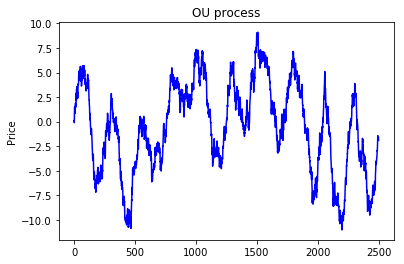

LL:-674.548341356
LL:-685.444999528
LL:-678.373541255
LL:-1281.86263975


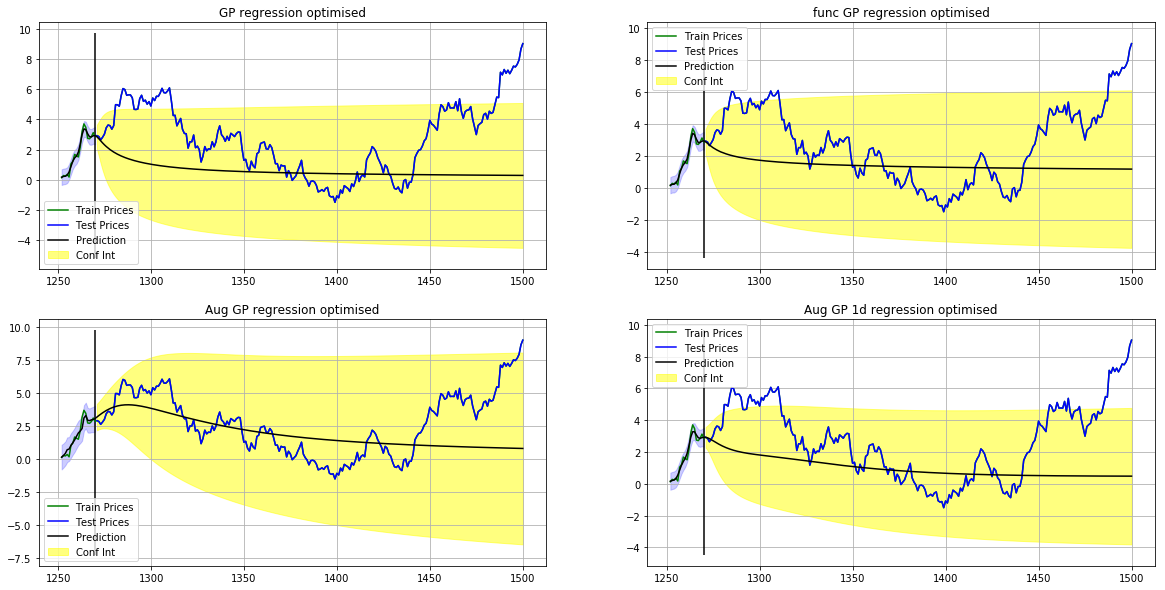

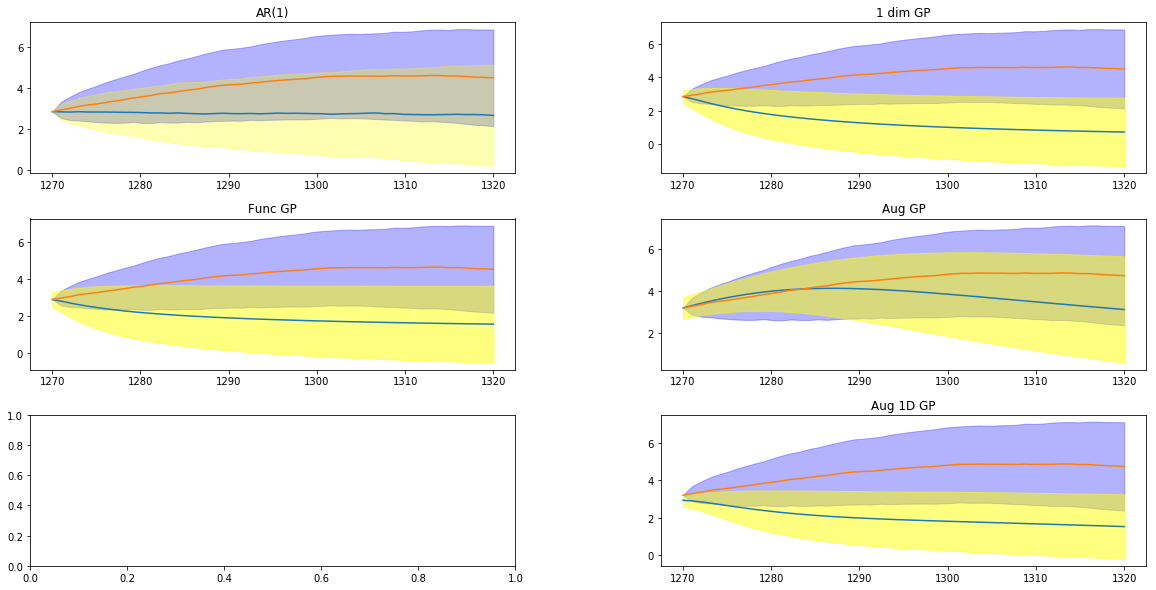

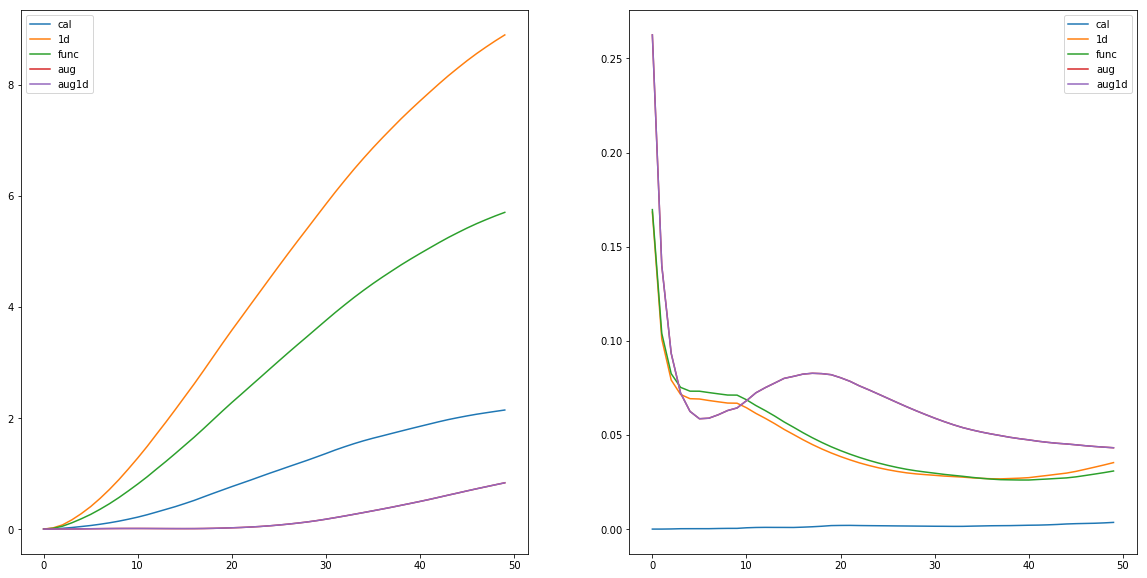

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s02  0003   2.617839e+03   6.893632e+05 
    03s09  0009   8.028553e+02   2.141611e+03 
    06s22  0018   7.502897e+02   1.990905e+02 
    11s48  0033   7.382513e+02   1.549567e+01 
    16s90  0048   7.379315e+02   1.674881e-01 
    18s66  0053   7.379310e+02   4.279634e-06 
Runtime:     18s66
Optimization status: Converged

Optimization restart 1/3, f = 737.9309738639666
Optimization restart 2/3, f = 737.9309847458876
Optimization restart 3/3, f = 737.9310013253756
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s24  0009   8.305866e+02   2.424448e+03 
    07s72  0021   7.567892e+02   3.138097e+02 
    12s05  0034   7.472121e+02           nan  

 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/paramz-0.7.3-py3.6.egg/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:invalid value encountered in less



    12s98  0037   7.472121e+02   1.145935e+01 
Runtime:     12s98
Optimization status: Converged

Optimization restart 1/3, f = 747.1030526932024
Optimization restart 2/3, f = 745.5338092547765
Optimization restart 3/3, f = 747.7149713107527
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0004   1.856294e+03   1.012299e+05 
    00s18  0005   1.406184e+03   1.463774e+04 
    02s40  0070   7.167522e+02   2.327743e+00 
Runtime:     02s40
Optimization status: Converged

Optimization restart 1/3, f = 716.7521793099206
Optimization restart 2/3, f = 716.6515245788815
Optimization restart 3/3, f = 717.406982295199
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    09s57  0012   1.557580e+03   1.084656e+04 
    15s93  0020   1.417077e+03   6.394484e+01 
    25s20  0032   1.406529e+03   9.628634e+02 
    36s46  0046   1.401616e+03   6.431387e+01 
    53s51  0068   1.401111e+03   2.707850e-01 
   

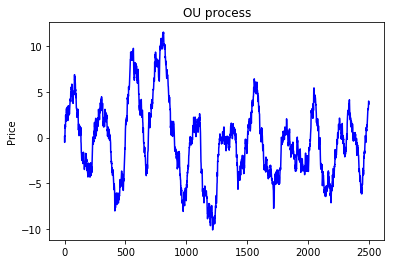

LL:-737.930973864
LL:-745.533809255
LL:-716.651524579
LL:-1401.10644153


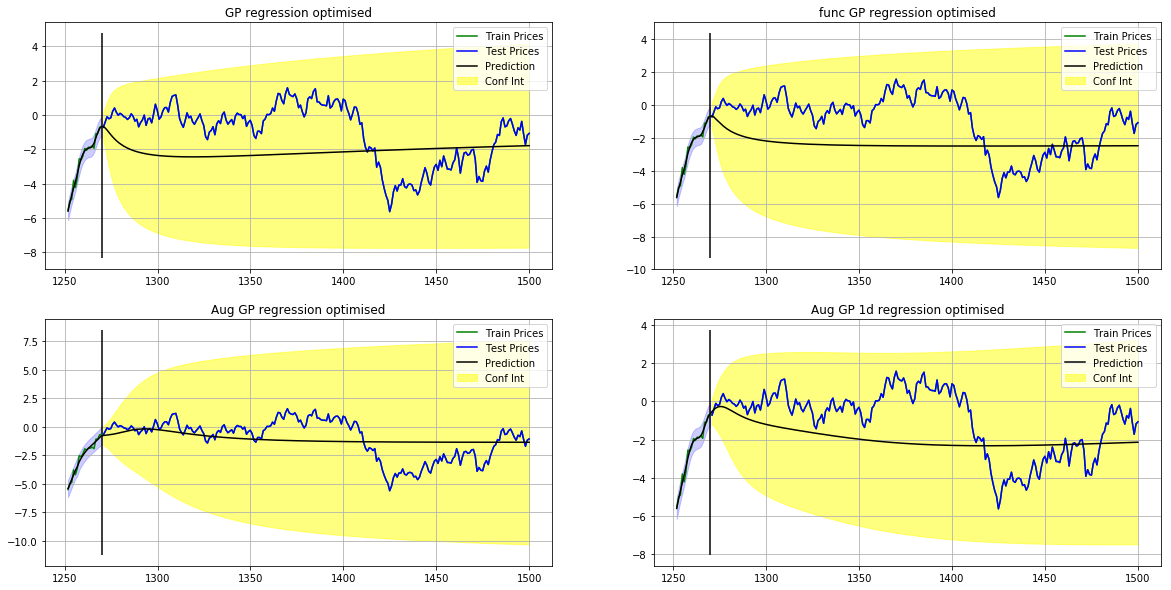

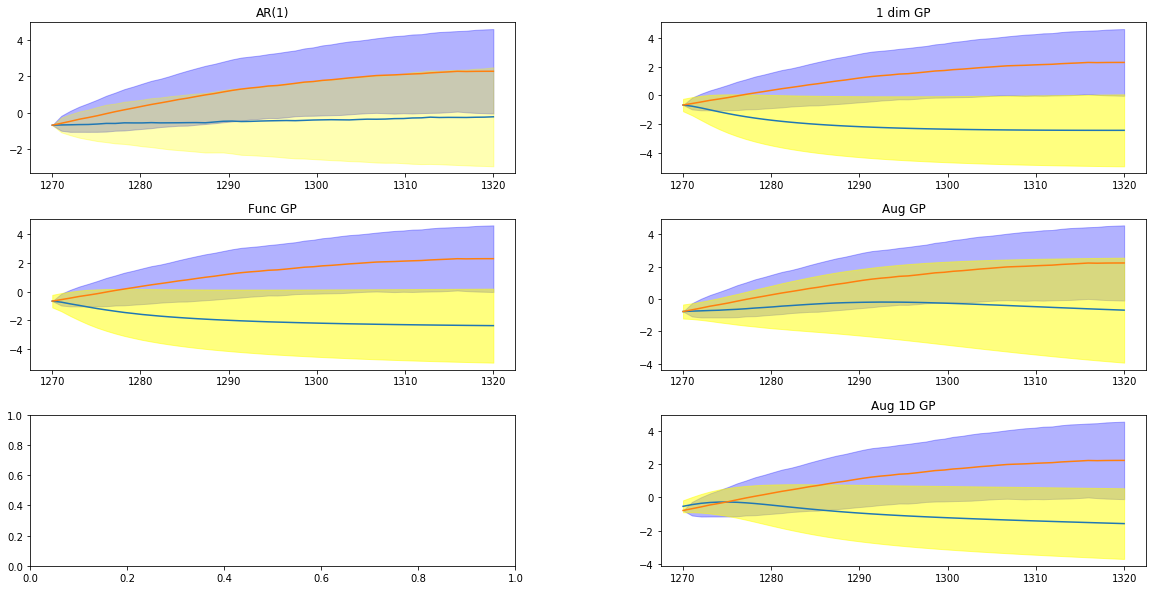

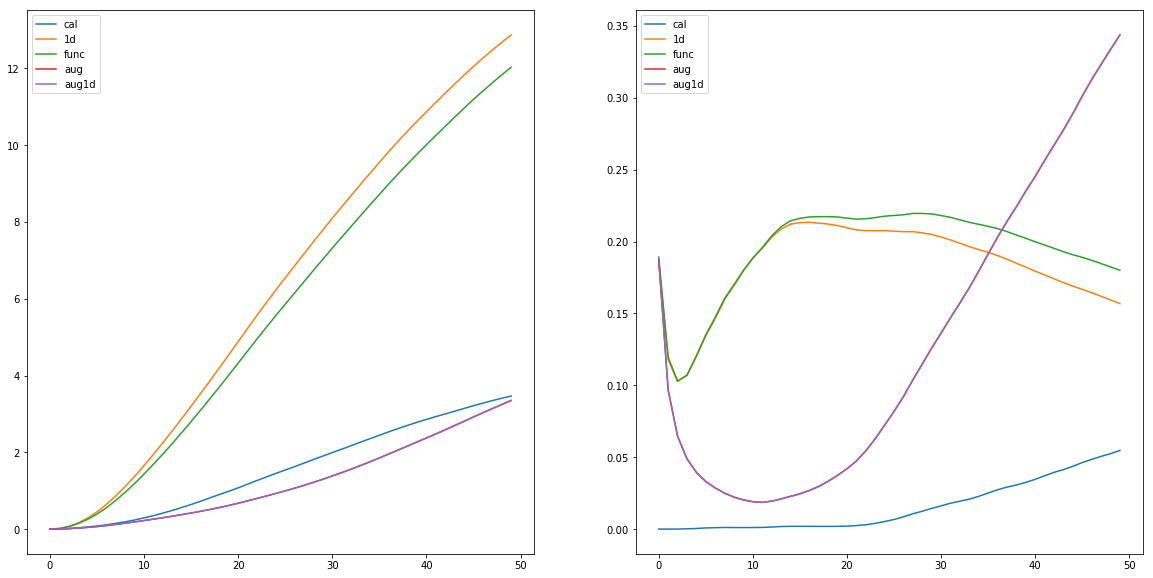

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   4.673539e+03           nan 
    01s06  0003   2.156476e+03   2.949326e+05 
    05s37  0015   7.775111e+02   4.652414e+02 
    10s88  0030   7.622977e+02   1.973617e+01 
    16s53  0045   7.615606e+02   9.667960e-02 
    20s58  0056   7.615534e+02   4.179768e-07 
Runtime:     20s58
Optimization status: Converged

Optimization restart 1/3, f = 761.5534378985046
Optimization restart 2/3, f = 761.5533599447743
Optimization restart 3/3, f = 761.5534819382708
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s18  0006   8.270185e+02   3.432504e+03 
    06s53  0018   7.726171e+02   3.448875e+01 
    12s22  0033   7.667201e+02   3.686276e+00 
    30s95  0083   7.667354e+02   3.686276e+00 
Runtime:     30s95
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'

Optimization restart 1/3, f = 766.7200693768716
Optimization restart 2/3

 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/paramz-0.7.3-py3.6.egg/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/3, f = 679.8730124697718
Optimization restart 2/3, f = 680.2887883143669
Optimization restart 3/3, f = 679.861930491353
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s47  0008   5.057207e+03   1.182572e+05 
    21s05  0026   1.398176e+03   1.691436e+02 
    58s69  0072   1.391468e+03   1.516893e+00 
 01m06s56  0081   1.391463e+03   6.221867e-03 
Runtime:  01m06s56
Optimization status: Converged

Optimization restart 1/3, f = 1391.4631125351063
Optimization restart 2/3, f = 1391.4892959670701
Optimization restart 3/3, f = 1391.5021924364628


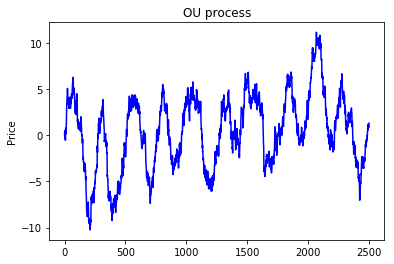

LL:-761.553359945
LL:-762.222823572
LL:-679.861930491
LL:-1391.46311254


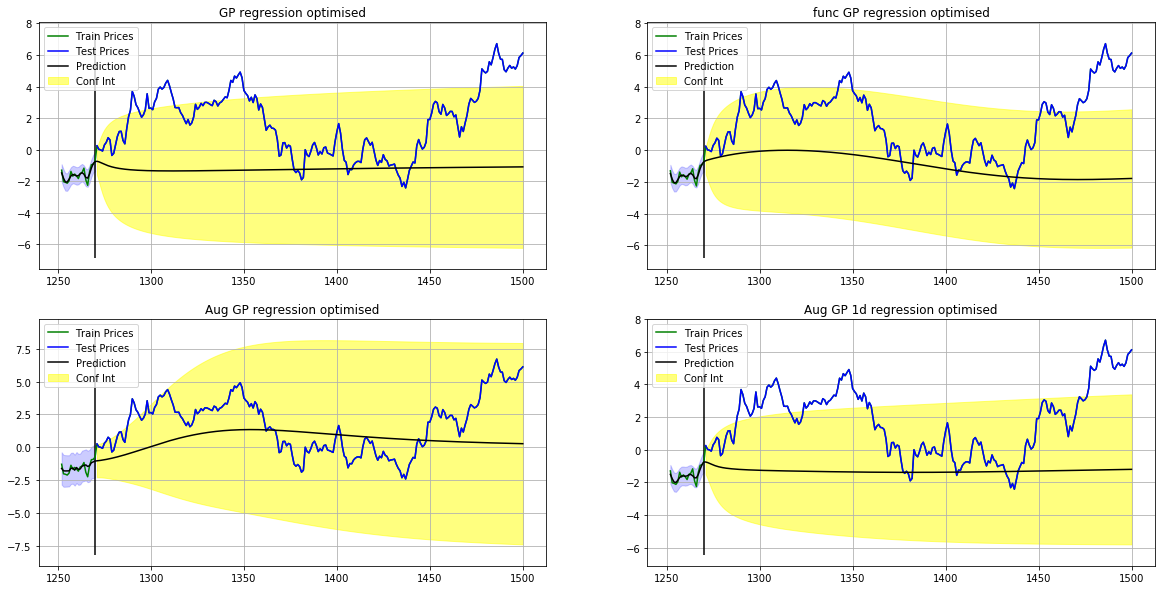

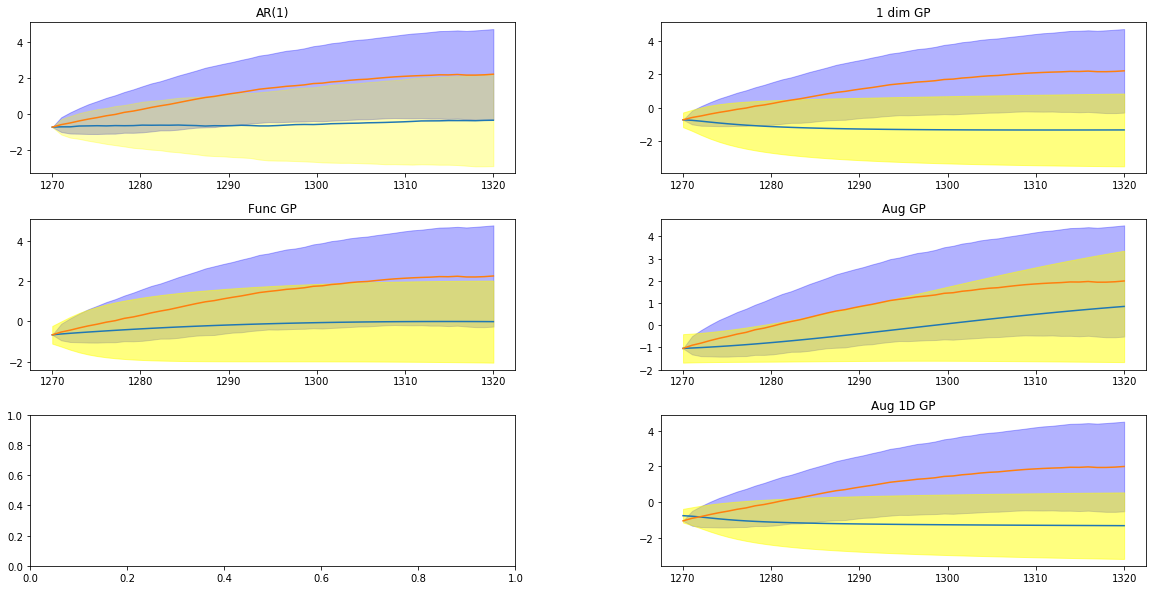

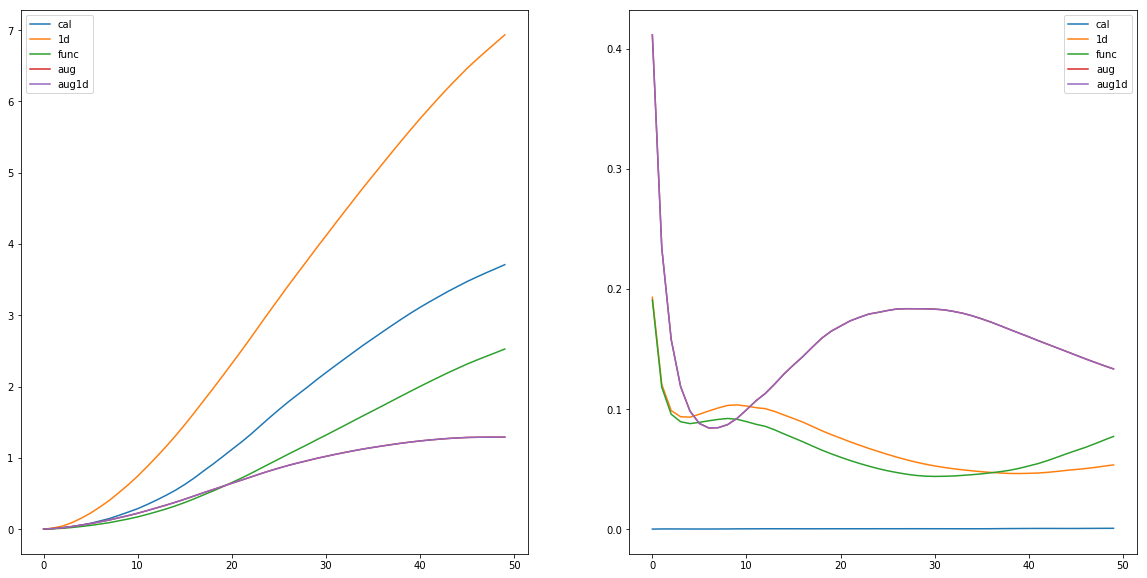

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s18  0009   7.798700e+02   3.935335e+02 
    08s75  0024   7.381474e+02   2.021086e+00 
    11s96  0033   7.367409e+02   1.188758e+01 
    18s56  0051   7.364975e+02   2.341151e-03 
    19s64  0054   7.364975e+02   7.933848e-06 
Runtime:     19s64
Optimization status: Converged

Optimization restart 1/3, f = 736.4835979370521
Optimization restart 2/3, f = 736.4924118454244
Optimization restart 3/3, f = 736.4974211096958
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   4.466690e+03           nan 
    04s55  0012   7.795405e+02   4.200032e+02 
    11s27  0030   7.416897e+02   1.012933e+01 
    20s63  0054   7.406119e+02   1.034022e-01 
    23s20  0061   7.406116e+02   1.027307e-05 
Runtime:     23s20
Optimization status: Converged

Optimization restart 1/3, f = 740.6115603872123
Optimization restart 2/3, f = 740.6131905362986
Optim

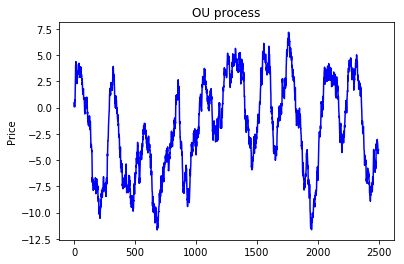

LL:-736.483597937
LL:-740.602615525
LL:-705.013292685
LL:-1388.20915825


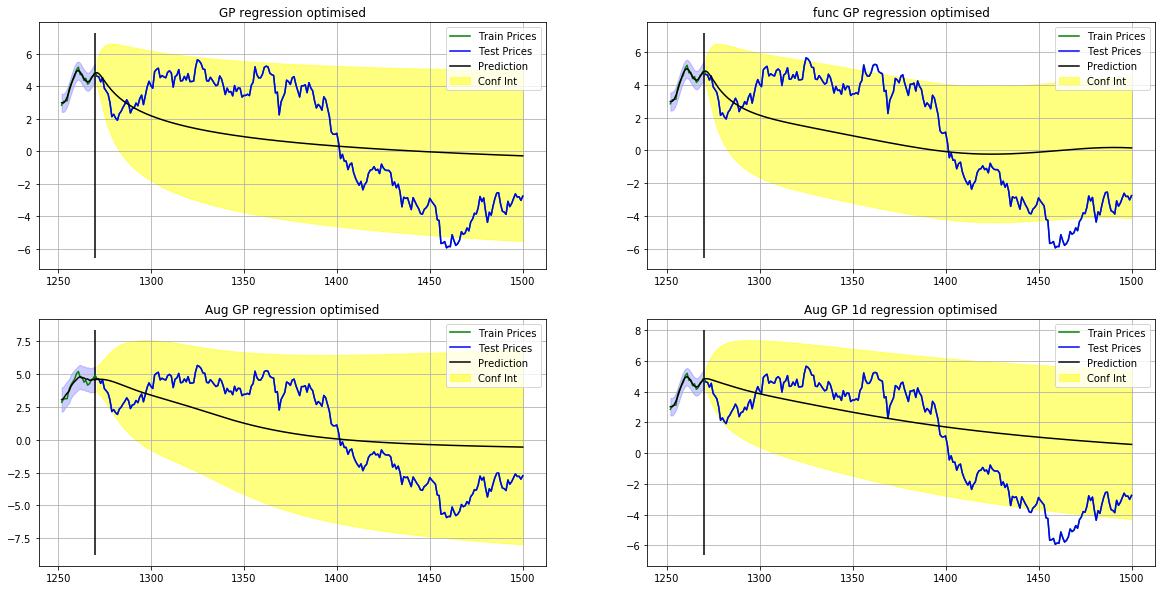

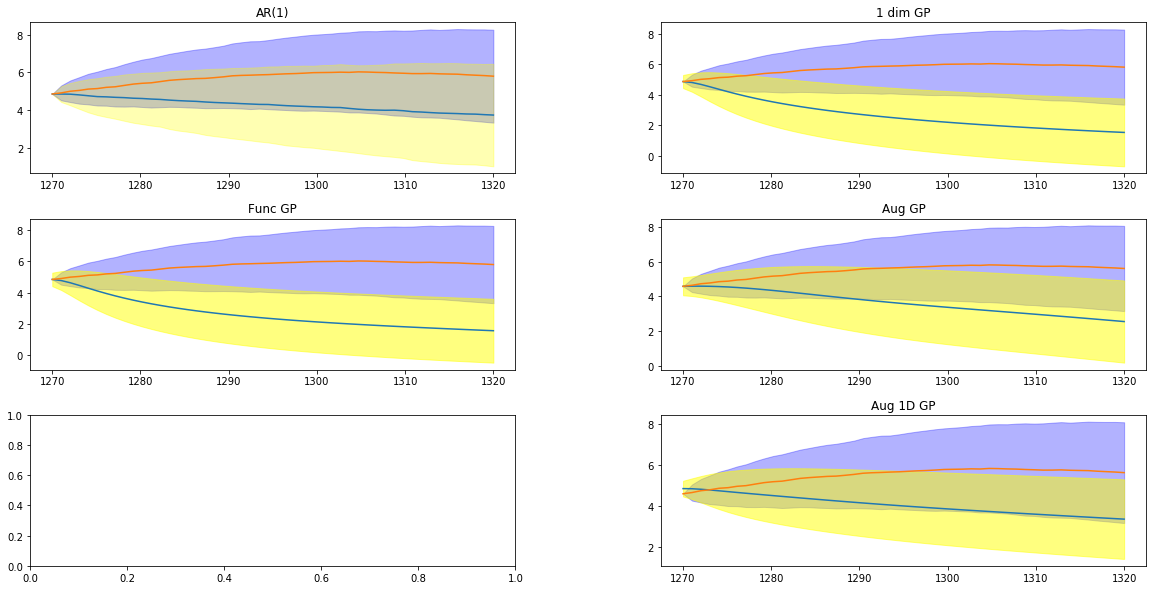

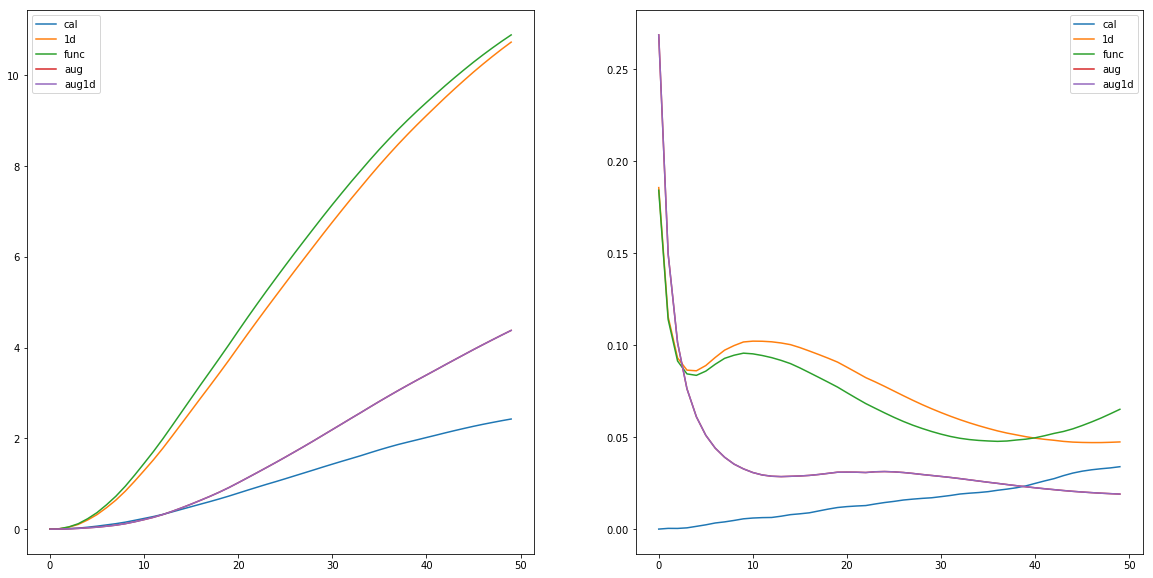

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s07  0003   2.095248e+03   2.560901e+05 
    04s28  0012   8.095761e+02   6.260308e+02 
    07s48  0021   7.795533e+02   8.235800e+01 
    15s10  0042   7.747731e+02   5.693442e+00 
    17s28  0048   7.747568e+02   1.224572e-03 
    18s48  0051   7.747568e+02   3.526806e-05 
Runtime:     18s48
Optimization status: Converged

Optimization restart 1/3, f = 774.7567753441588
Optimization restart 2/3, f = 774.7567785489586
Optimization restart 3/3, f = 774.7568842329273
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s33  0009   8.048927e+02   7.821547e+02 
    06s68  0018   7.693635e+02   1.742200e+02 
    11s06  0030   7.620180e+02   1.985778e+01 
    17s89  0048   7.614818e+02   3.831594e-02 
    20s03  0054   7.614814e+02   4.545097e-06 
    20s39  0055   7.614814e+02   4.545097e-06 
Runtime:     20s39
Optimization status: Converged

Optimi

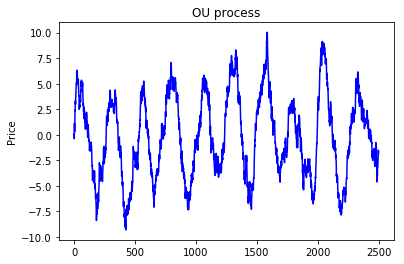

LL:-774.756775344
LL:-761.481359404
LL:-666.698027375
LL:-1417.88256173


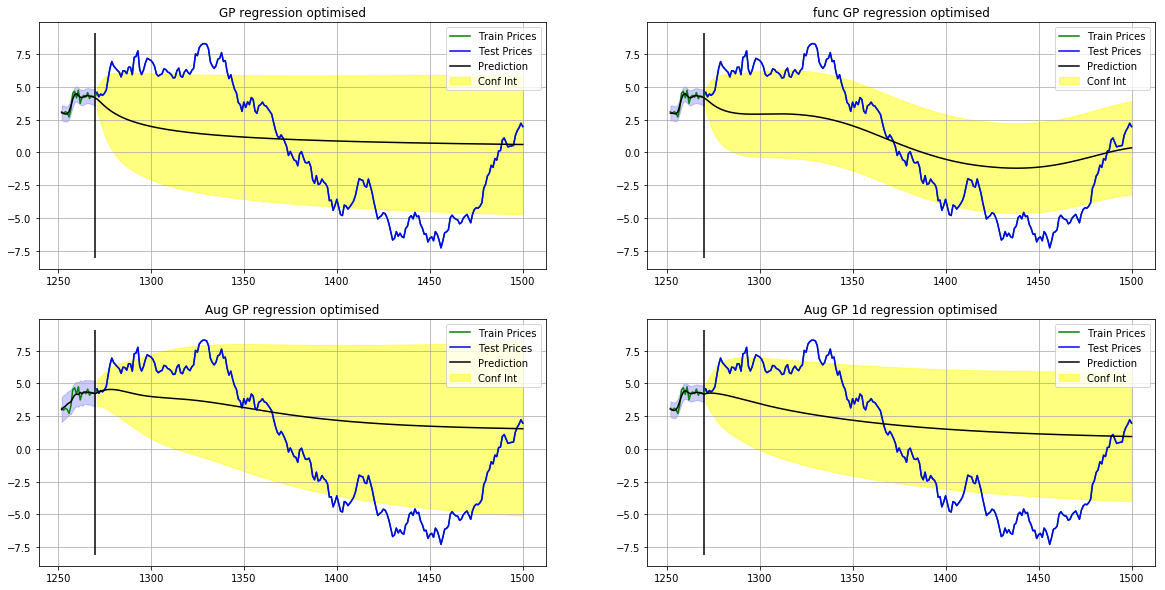

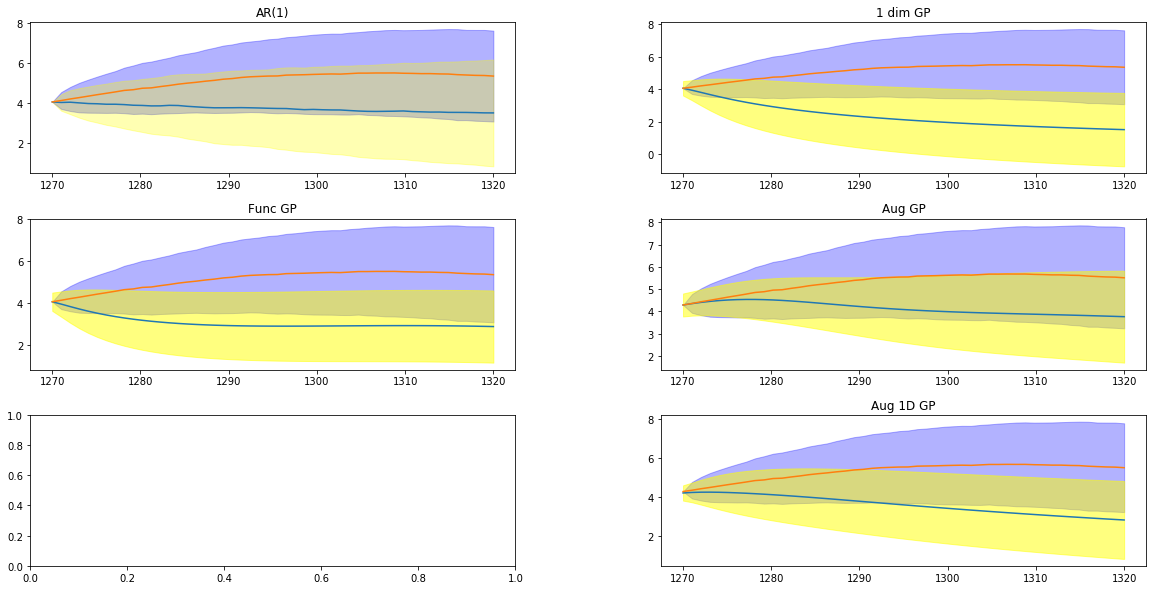

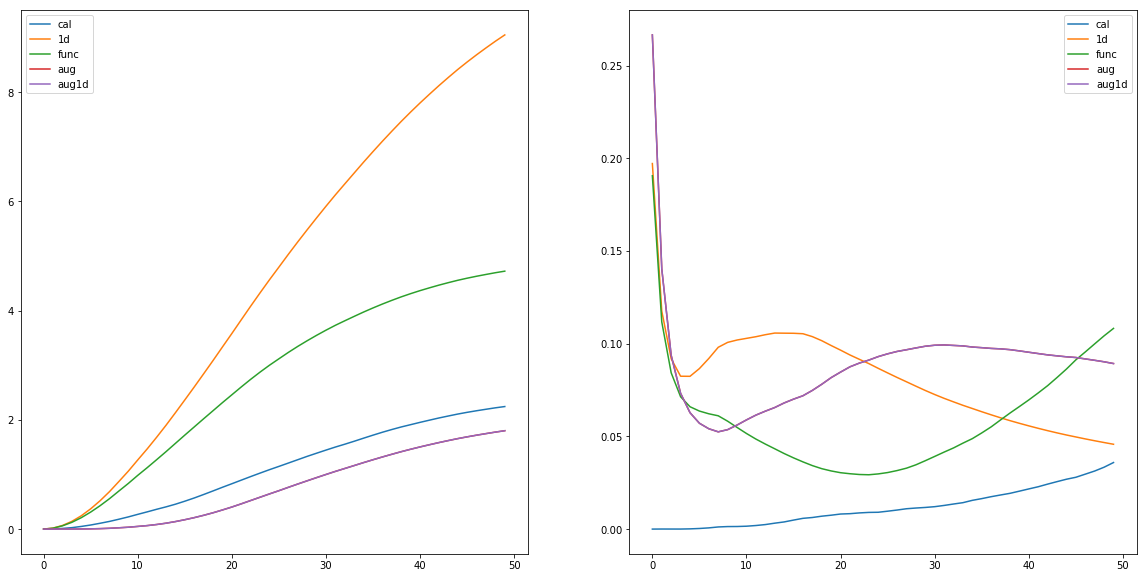

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s20  0009   9.237187e+02   1.237934e+04 
    06s42  0018   8.231529e+02   3.705750e+02 
    08s63  0024   8.095266e+02   7.742139e+01 
    17s50  0048   8.055937e+02   1.765794e-01 
    20s20  0055   8.055913e+02   3.361806e-06 
Runtime:     20s20
Optimization status: Converged

Optimization restart 1/3, f = 805.5912971513859
Optimization restart 2/3, f = 805.5912983575145
Optimization restart 3/3, f = 805.5913101375526
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s21  0003   2.958396e+03   6.312448e+05 
    03s46  0009   9.157417e+02   2.208371e+03 
    08s00  0021   8.218886e+02   4.486208e+02 
    21s50  0057   3.903159e+03   2.671031e+04 
    40s73  0109   8.149347e+02   1.468306e-01 
Runtime:     40s73
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'

Optimization restart 1/3, f = 814.8739044673364
Optimization restart 2/

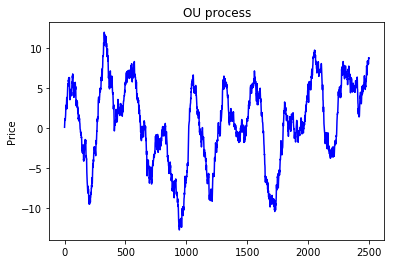

LL:-805.591297151
LL:-811.815447783
LL:-755.988426855
LL:-1527.50568881


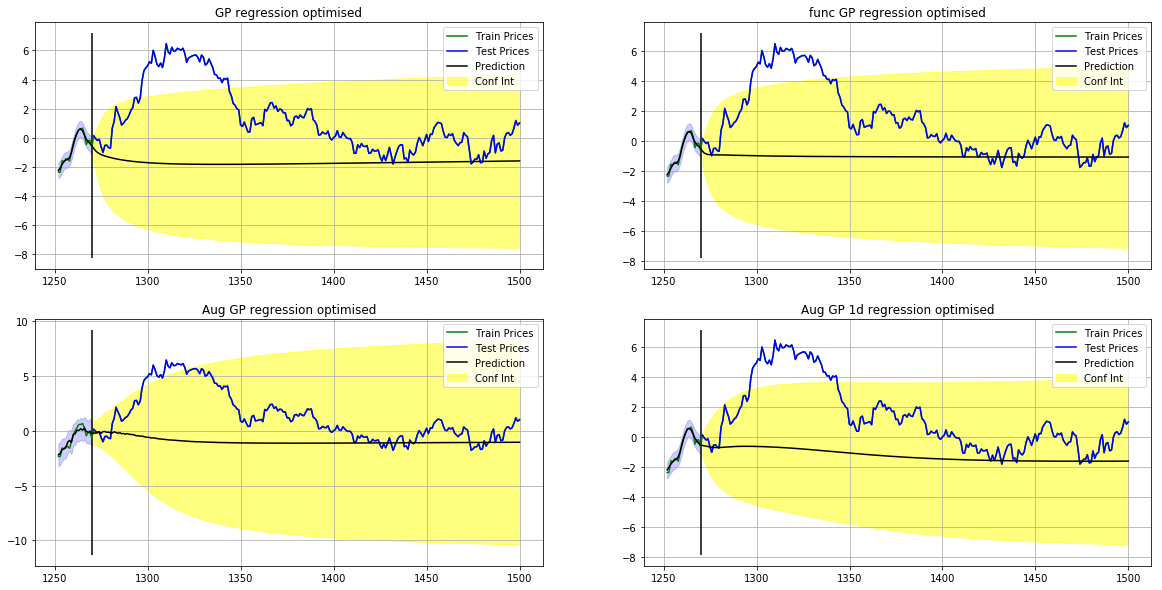

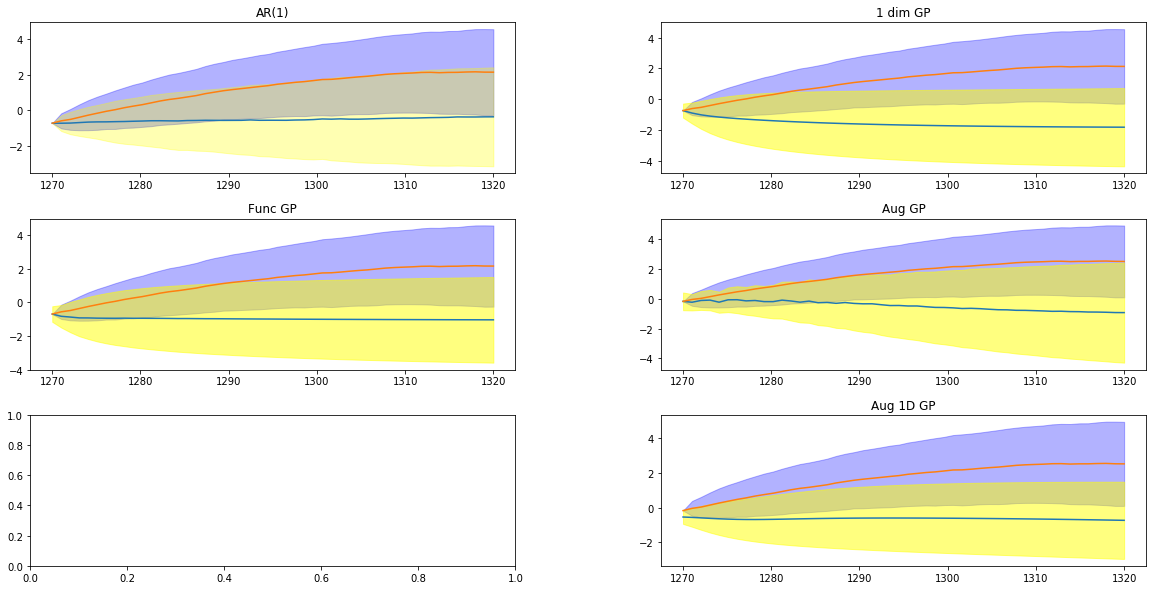

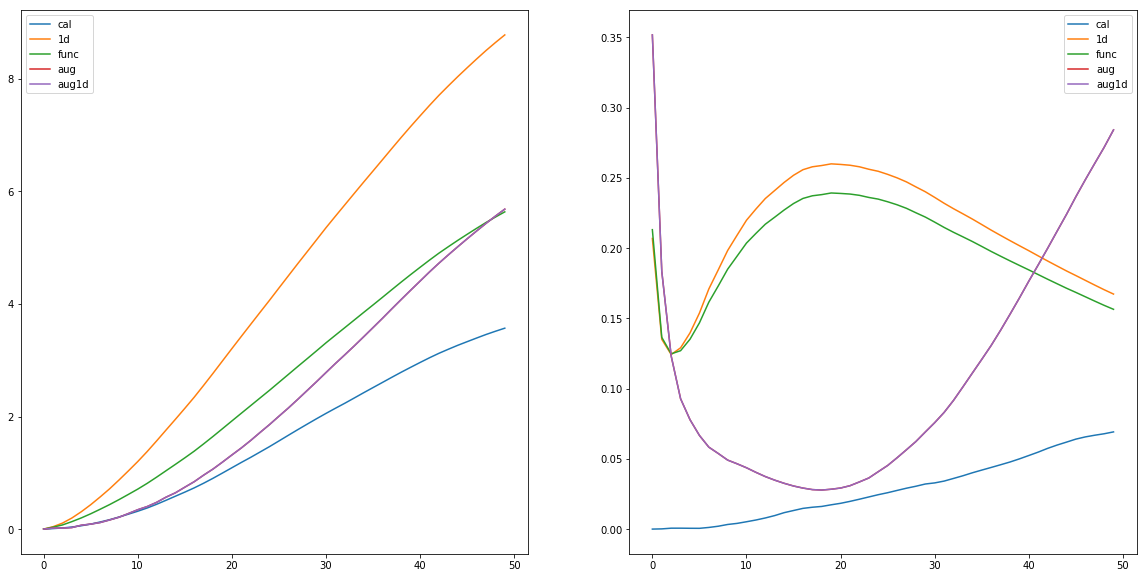

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    05s39  0015   7.565473e+02   6.912517e+01 
    07s55  0021   7.432340e+02   3.186624e+01 
    14s11  0039   7.392659e+02   1.128925e+00 
    16s31  0045   7.391949e+02   1.673789e+00 
    19s71  0054   7.391864e+02   4.594613e-06 
Runtime:     19s71
Optimization status: Converged

Optimization restart 1/3, f = 739.1863866194051
Optimization restart 2/3, f = 739.1862875264895
Optimization restart 3/3, f = 739.1864770538741
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   6.094916e+03           nan 
    03s52  0009   8.099825e+02   1.132660e+03 
    09s01  0024   7.548894e+02   3.551932e+01 
    11s48  0032   7.533229e+02   1.542892e+01 
Runtime:     11s48
Optimization status: Converged

Optimization restart 1/3, f = 752.803899066499
Optimization restart 2/3, f = 751.6885580468229
Optimization restart 3/3, f = 753.4631248304677
Runni

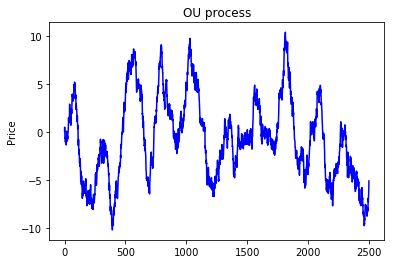

LL:-739.186287526
LL:-751.688558047
LL:-716.502429872
LL:-1378.21150358


 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning:invalid value encountered in sqrt


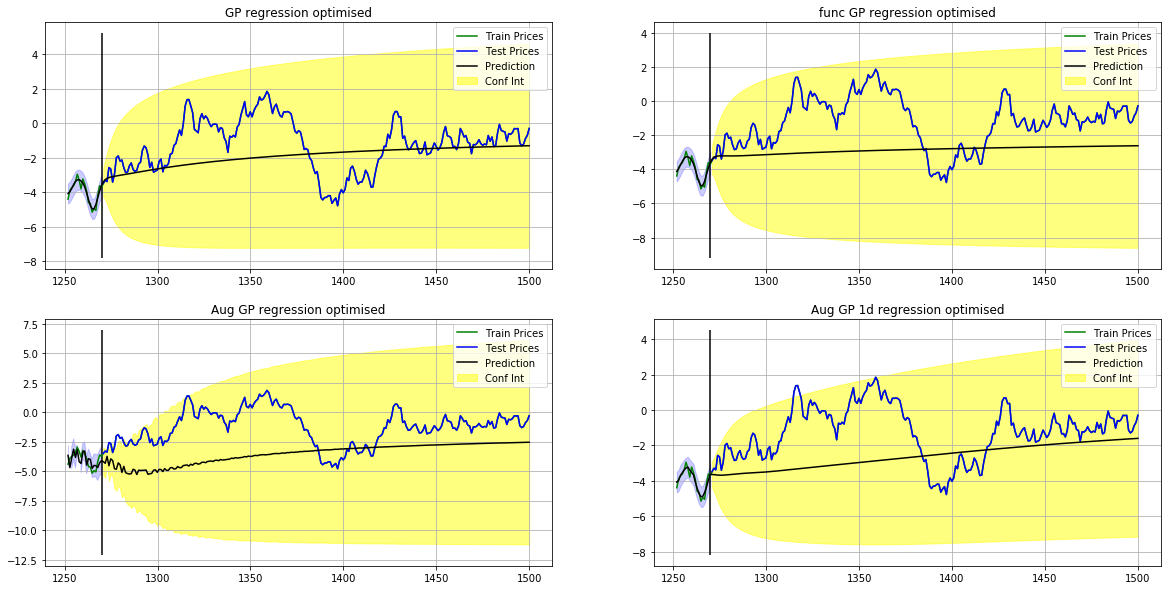

 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning:invalid value encountered in sqrt


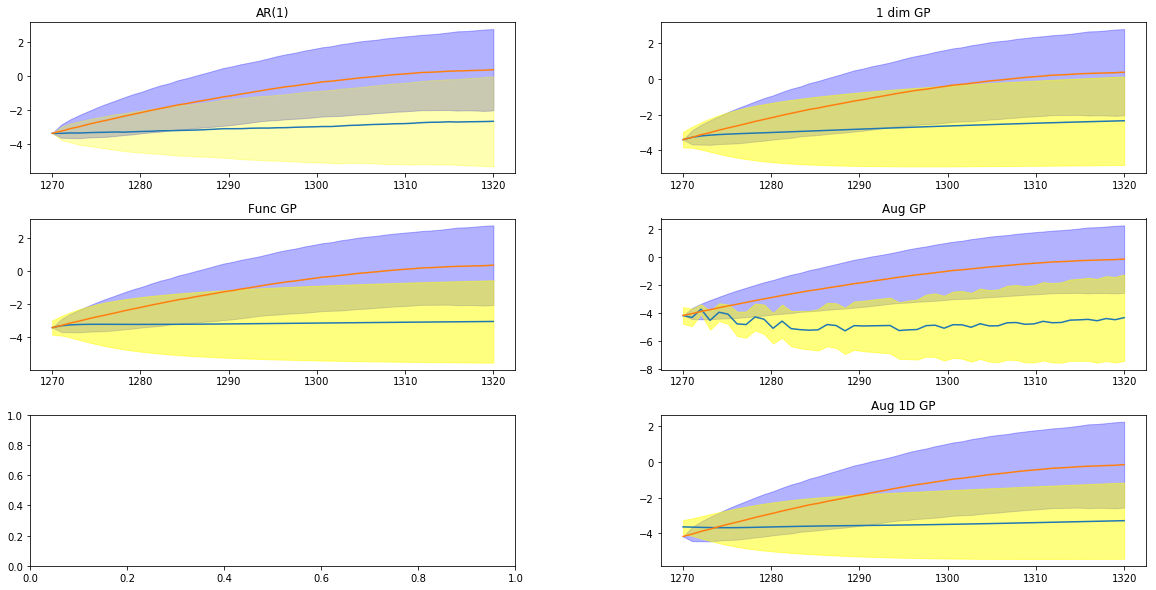

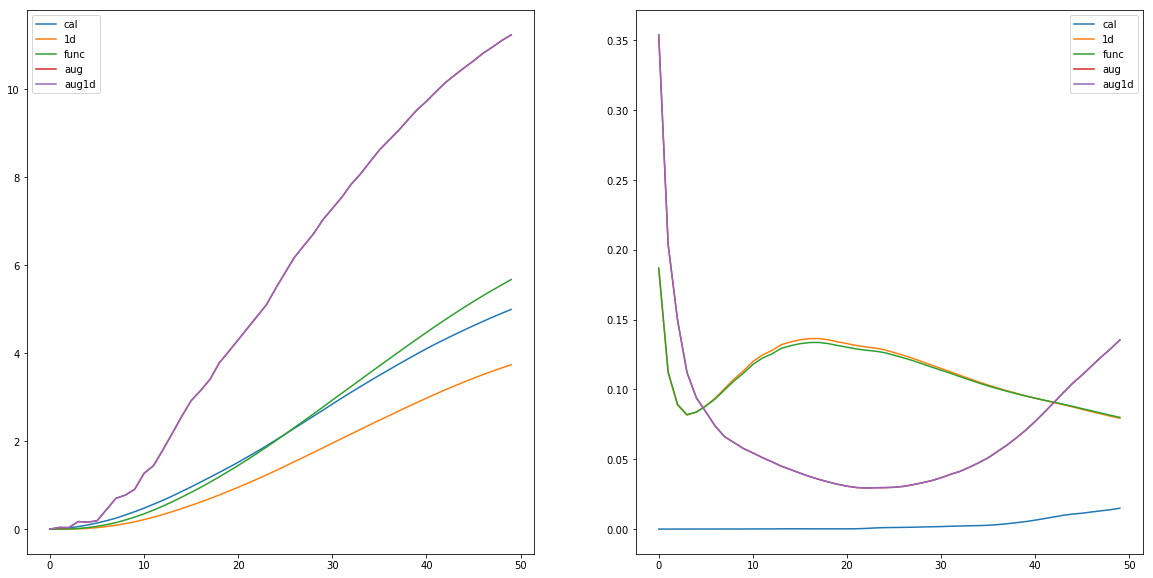

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s27  0012   7.248521e+02   1.242362e+03 
    11s87  0033   7.061106e+02   3.614159e+02 
    17s41  0048   7.052677e+02   1.044852e+00 
    19s99  0055   7.052649e+02   2.377403e-07 
Runtime:     19s99
Optimization status: Converged

Optimization restart 1/3, f = 705.2648611683674
Optimization restart 2/3, f = 705.2651584388624
Optimization restart 3/3, f = 705.2648078271168
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s29  0006   8.033196e+02   2.637565e+04 
    04s66  0012   7.333250e+02   9.432369e+02 
    14s90  0039   7.158000e+02   4.525125e+01 
    21s50  0057   7.158069e+02   3.414183e+00 
    50s52  0134   7.157694e+02   4.172523e+00 
Runtime:     50s52
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'

Optimization restart 1/3, f = 715.745421102607


 /Users/johngoodacre/anaconda/envs/gp/lib/python3.6/site-packages/GPy/kern/src/stationary.py:158: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/3, f = 714.7345884893014
Optimization restart 3/3, f = 714.6087363913975
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0004   1.520147e+03   5.601948e+04 
    01s33  0039   7.097271e+02   2.684370e+00 
Runtime:     01s33
Optimization status: Converged

Optimization restart 1/3, f = 708.8997351775611
Optimization restart 2/3, f = 709.3399432698983
Optimization restart 3/3, f = 710.3257857343867
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s34  0008   1.811914e+03   1.219681e+05 
    20s66  0026   1.365105e+03   2.223291e+01 
    50s74  0064   1.361316e+03   2.628546e-01 
    56s27  0071   1.361316e+03   1.131458e-04 
Runtime:     56s27
Optimization status: Converged

Optimization restart 1/3, f = 1361.3156771139265
Optimization restart 2/3, f = 1361.3154640645334
Optimization restart 3/3, f = 1361.3132819877096


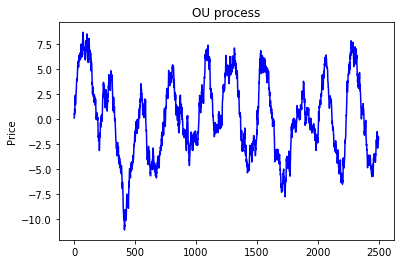

LL:-705.264807827
LL:-714.608736391
LL:-708.899735178
LL:-1361.31328199


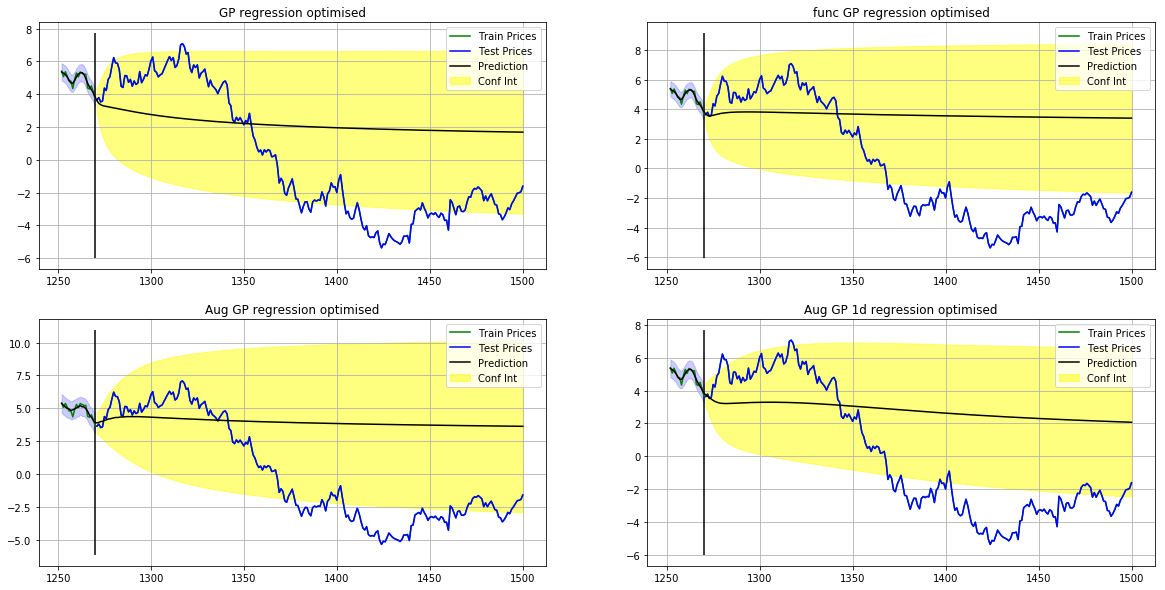

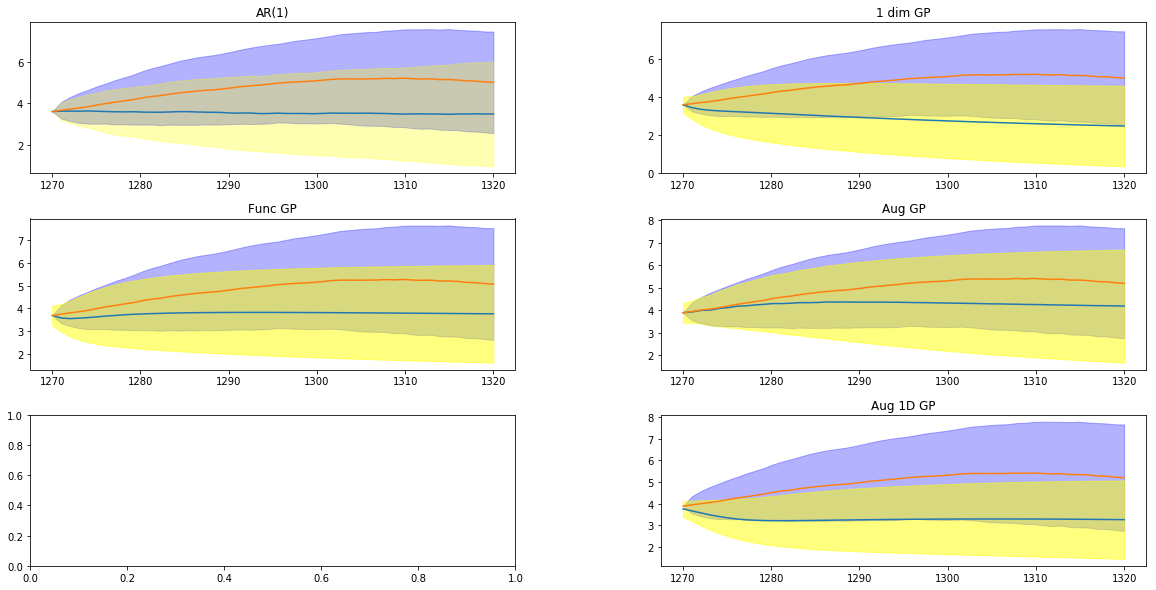

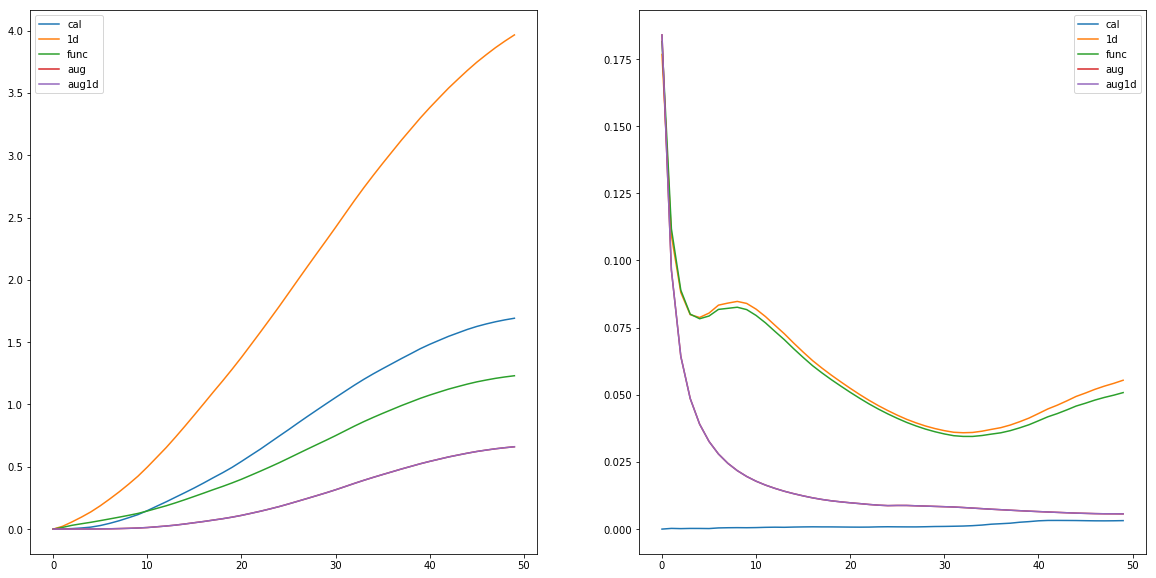

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s06  0003   2.313305e+03   4.034166e+05 
    02s13  0006   2.434497e+03   5.031032e+06 
    06s42  0018   7.828293e+02   1.223272e+02 
    15s18  0042   7.765003e+02   8.163986e-01 
    19s95  0055   7.764652e+02   6.123743e-05 
Runtime:     19s95
Optimization status: Converged

Optimization restart 1/3, f = 776.4651591687224
Optimization restart 2/3, f = 776.4652513313033
Optimization restart 3/3, f = 776.465176459969
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s51  0009   8.449696e+02   5.027900e+02 
    09s14  0024   7.876861e+02   3.435001e+01 
    11s39  0030   7.861653e+02   1.849968e+00 
    13s57  0036   7.860622e+02   2.565413e-01 
    31s16  0083   7.857508e+02   7.909836e-02 
Runtime:     31s16
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'

Optimization restart 1/3, f = 785.7507690020824
Optimization restart 2/3

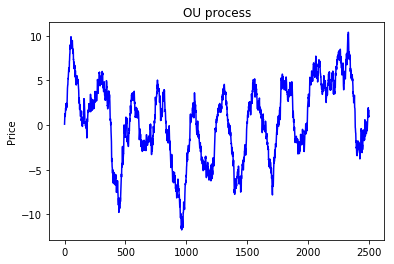

LL:-776.465159169
LL:-784.386589078
LL:-702.388485522
LL:-1444.55683794


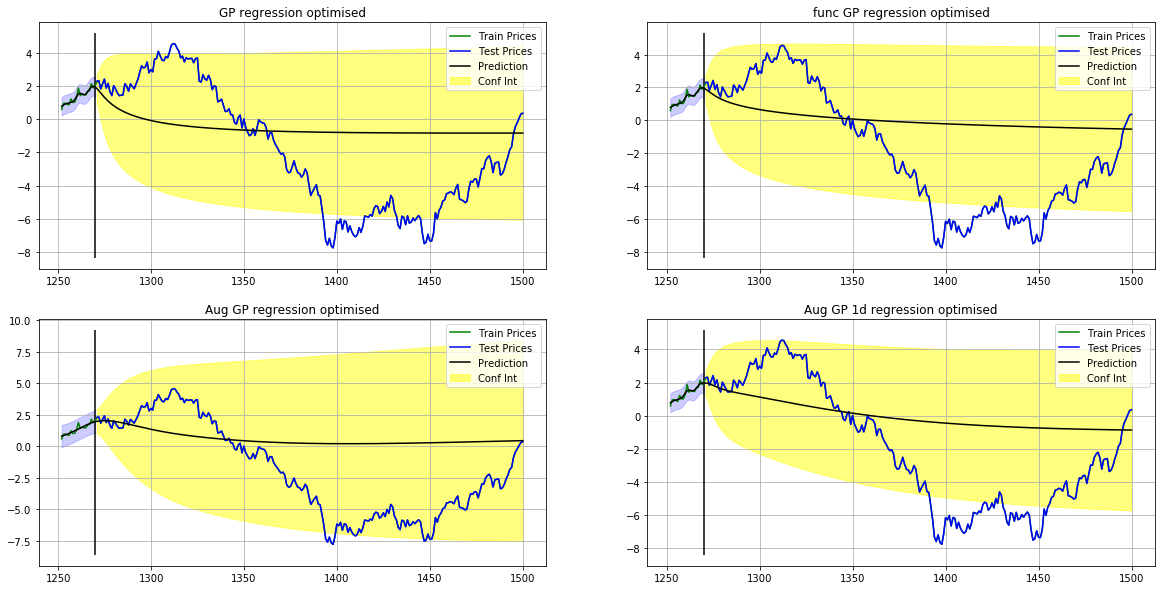

In [ ]:
sigmas = np.linspace(0.38,0.38,1)
for sigma in sigmas:
    seed = range(0,10,1)
    for seed in seed:
        results =do_run(seed,add_seas,laplace,sigma,kern,years,days,obs_year,obs_day,reset2zero,
                        max_delta, samples,restarts, results)

In [ ]:
results

In [ ]:
noiseg = np.random.normal(loc=0.0,size=1000)
noiset = np.random.standard_t(3, size=1000)
plt.hist(noiset, bins=15)
plt.hist(noiseg, bins=15)

In [ ]:
#now look at student t noise #################################
tres5 = pd.read_csv('resultskerratt51.csv')
tres5= tres5.drop(res.columns[[0]], axis=1)

ar_tres5=  tres5[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres5_results = ar_tres5.groupby(['Noise']).mean()
ar_tres5_results

In [ ]:
ar_tres5_sd=  tres5[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres5_sd_results = ar_tres5_sd.groupby(['Noise']).mean()
ar_tres5_sd_results

In [ ]:
#now look at student t noise #################################
tres3 = pd.read_csv('resultskerratt31.csv')
tres3= tres3.drop(res.columns[[0]], axis=1)

ar_tres3=  tres3[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres3_results = ar_tres3.groupby(['Noise']).mean()
ar_tres3_results

In [ ]:
ar_tres3_sd=  tres3[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres3_sd_results = ar_tres3_sd.groupby(['Noise']).mean()
ar_tres3_sd_results

In [ ]:
#now look at student t noise #################################
tres1 = pd.read_csv('resultskerratt11.csv')
tres1= tres1.drop(res.columns[[0]], axis=1)

ar_tres1=  tres1[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres1_results = ar_tres1.groupby(['Noise']).mean()


ar_tres1_sd=  tres1[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres1_sd_results = ar_tres1_sd.groupby(['Noise']).mean()
ar_tres1_results
#ar_tres1_sd_results

In [ ]:
#now look at student t noise #################################
tres2 = pd.read_csv('resultskerratt21.csv')
tres2= tres2.drop(res.columns[[0]], axis=1)

ar_tres2=  tres1[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres2_results = ar_tres2.groupby(['Noise']).mean()


ar_tres2_sd=  tres2[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres2_sd_results = ar_tres2_sd.groupby(['Noise']).mean()
ar_tres2_results
ar_tres2_sd_results

In [ ]:
#now look at student t noise #################################
tres15 = pd.read_csv('resultskerratt15.csv')
tres15= tres15.drop(res.columns[[0]], axis=1)

ar_tres15=  tres15[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres15_results = ar_tres15.groupby(['Noise']).mean()


ar_tres15_sd=  tres15[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres15_sd_results = ar_tres15_sd.groupby(['Noise']).mean()
ar_tres15_results
ar_tres15_sd_results

In [ ]:
#now look at student t noise #################################
tres20 = pd.read_csv('resultskerratt201.csv')
tres20= tres20.drop(res.columns[[0]], axis=1)

ar_tres20=  tres20[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres20_results = ar_tres20.groupby(['Noise']).mean()


ar_tres20_sd=  tres20[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres20_sd_results = ar_tres20_sd.groupby(['Noise']).mean()
ar_tres20_results
ar_tres20_sd_results

In [ ]:
#now look at student t noise #################################
tres50 = pd.read_csv('resultskerratt501.csv')
tres50= tres50.drop(res.columns[[0]], axis=1)

ar_tres50=  tres50[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres50_results = ar_tres50.groupby(['Noise']).mean()


ar_tres50_sd=  tres50[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres50_sd_results = ar_tres50_sd.groupby(['Noise']).mean()
ar_tres50_results
ar_tres50_sd_results

In [ ]:
#now look at student t noise #################################
tres100 = pd.read_csv('resultskerratt1001.csv')
tres100= tres100.drop(res.columns[[0]], axis=1)

ar_tres100=  tres100[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres100_results = ar_tres100.groupby(['Noise']).mean()


ar_tres100_sd=  tres100[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres100_sd_results = ar_tres100_sd.groupby(['Noise']).mean()
ar_tres100_results
#ar_tres100_sd_results

In [ ]:
#now look at student t noise #################################
tres1000 = pd.read_csv('resultskerratt10001.csv')
tres1000= tres1000.drop(res.columns[[0]], axis=1)

ar_tres1000=  tres1000[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_tres1000_results = ar_tres1000.groupby(['Noise']).mean()


ar_tres1000_sd=  tres1000[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]
ar_tres1000_sd_results = ar_tres1000_sd.groupby(['Noise']).mean()
ar_tres1000_results
ar_tres1000_sd_results

In [ ]:
tres1

In [ ]:
res5 = pd.read_csv('results5.csv')

In [ ]:
res1 = pd.read_csv('results1.csv')

In [ ]:
res15 = pd.read_csv('results15.csv')

In [ ]:
res_ou1 = pd.read_csv('resultskerou.csv')
res_ou2 = pd.read_csv('resultskerou2.csv')
res_ou3 = pd.read_csv('resultskerou4.csv')
res_ou4 = pd.read_csv('resultskerou5.csv')
res_ou5 = pd.read_csv('resultskerou6.csv')
res_ou = pd.concat([res_ou1,res_ou2,res_ou3,res_ou4,res_ou5]).reset_index(drop=True)
res_ou


In [ ]:
res_ou = res_ou.drop(res.columns[[0]], axis=1)
res_ou.to_csv('ou_kern_noise1.csv')
ar_ou=  res_ou[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_ou_results = ar_ou.groupby(['Noise']).mean()
ar_ou_results

In [ ]:
res_rbf1 = pd.read_csv('resultskerrbf.csv')
res_rbf2 = pd.read_csv('resultskerrbf2.csv')
res_rbf3 = pd.read_csv('resultskerrbf3.csv')

res_rbf = pd.concat([res_rbf1,res_rbf2,res_rbf3]).reset_index(drop=True)

res_rbf = res_rbf.drop(res.columns[[0]], axis=1)
res_rbf

In [ ]:
res_rbf.to_csv('rbf_kern_noise1.csv')
ar_rbf=  res_rbf[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_rbf_results = ar_rbf.groupby(['Noise']).mean()
ar_rbf_results

In [ ]:
res_mat = pd.read_csv('resultskerrmat.csv')
res_mat


In [ ]:
res_mat = res_mat.drop(res.columns[[0]], axis=1)
res_mat.to_csv('mat_kern_noise1.csv')
ar_mat=  res_mat[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_mat_results = ar_mat.groupby(['Noise']).mean()
ar_mat_results

In [ ]:
res_ou75 = pd.read_csv('resultskerou75.csv')
res_ou752 = pd.read_csv('resultskerou751.csv')
res_ou7510 = pd.read_csv('resultskerou7510.csv')
res_ou7511 = pd.read_csv('resultskerou7511.csv')
res_ou7512 = pd.read_csv('resultskerou7512.csv')
res_ou752 = pd.read_csv('resultskerou752.csv')
res_ou753 = pd.read_csv('resultskerou753.csv')
res_ou754 = pd.read_csv('resultskerou754.csv')
res_ou755 = pd.read_csv('resultskerou755.csv')
res_ou756 = pd.read_csv('resultskerou756.csv')
res_ou757 = pd.read_csv('resultskerou757.csv')
res_ou758 = pd.read_csv('resultskerou758.csv')
res_ou759 = pd.read_csv('resultskerou759.csv')

res_ou75_res= pd.concat([res_ou75,res_ou752,res_ou7510,res_ou7511,res_ou7512,
                        res_ou752,res_ou753, res_ou754,res_ou755,res_ou756
                        ,res_ou757,res_ou758,res_ou759]).reset_index(drop=True)

res_ou75_results = res_ou75_res.drop(res.columns[[0]], axis=1)
res_ou75_results

In [ ]:
res_ou75_results.to_csv('ou_kern_noise75.csv')
ar_res75=  res_ou75_results[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30'
             ,'FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30'
             ,'AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]
ar_res75 = ar_res75.groupby(['Noise']).mean()
ar_res75

In [ ]:
res = pd.concat([res15,res1,res5]).reset_index(drop=True)
res.columns

In [ ]:
res = res.drop(res.columns[[0]], axis=1)

In [ ]:
res.to_csv('mat_noisetst_withfeatures1.csv')

In [ ]:
ar=  res[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30','FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30','AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']]

In [ ]:
ar_results = ar.groupby(['Noise']).mean()
ar_results

In [ ]:
tenday_pred = ar_results[['AR1_MSE_10','1D_MSE_10','FUNC_MSE_10','AUG_MSE_10','AUD1D_MSE_10']]

In [ ]:

ax1 = tenday_pred.plot()
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:5], labels[:5], loc='best')

In [ ]:
twentyday_pred = ar_results[['AR1_MSE_20','1D_MSE_20','FUNC_MSE_20','AUG_MSE_20','AUG1D_MSE_20']]

In [ ]:
ax1 = twentyday_pred.plot()
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:5], labels[:5], loc='best')

In [ ]:
thirtyday_pred = ar_results[['AR1_MSE_30','1D_MSE_30','FUNC_MSE_30','AUG_MSE_30','AUG1D_MSE_30']]
ax1 = thirtyday_pred.plot()
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:5], labels[:5], loc='best')

In [ ]:
thirtyday_pred

In [ ]:
res20 = pd.read_csv('results20.csv')


res_test = pd.concat([res15,res1,res5, res20]).reset_index(drop=True)
res_test

In [ ]:
res_test = res_test.drop(res.columns[[0]], axis=1)

In [ ]:
ar_test=  res_test[['AR1_MSE_10','AR1_MSE_20','AR1_MSE_30','1D_MSE_10','1D_MSE_20','1D_MSE_30','FUNC_MSE_10','FUNC_MSE_20','FUNC_MSE_30','AUG_MSE_10','AUG_MSE_20','AUG_MSE_30','AUD1D_MSE_10','AUG1D_MSE_20','AUG1D_MSE_30','Noise']
                  ]

In [ ]:
ar_test_results = ar_test.groupby(['Noise']).mean()
print(ar_test_results[['AR1_MSE_20', '1D_MSE_20', 'FUNC_MSE_20', 'AUG_MSE_20', 'AUG1D_MSE_20']].to_latex())

In [ ]:
ar_test_sd=  res_test[['AR1_MSESD_10','AR1_MSESD_20','AR1_MSESD_30','1D_MSESD_10','1D_MSESD_20','1D_MSESD_30',
                       'FUNC_MSESD_10','FUNC_MSESD_20','FUNC_MSESD_30','AUG_MSESD_10','AUG_MSESD_20',
                       'AUG_MSESD_30','AUG1D_MSESD_10','AUG1D_MSESD_20','AUG1D_MSESD_30','Noise']]

ar_test_sd_results = ar_test_sd.groupby(['Noise']).mean()
ar_sd = ar_test_sd_results[['AR1_MSESD_30', '1D_MSESD_30', 'FUNC_MSESD_30', 'AUG_MSESD_30', 'AUG1D_MSESD_30']]
print(ar_sd.to_latex()     )   

In [ ]:
tenday_pred = ar_test_results[['AR1_MSE_10','1D_MSE_10','FUNC_MSE_10','AUG_MSE_10','AUD1D_MSE_10']]


plt.plot(tenday_pred['AR1_MSE_10'], label='AR(1)')
plt.plot(tenday_pred['1D_MSE_10'], label='Std GP')
plt.plot(tenday_pred['FUNC_MSE_10'], label='Func GP')
plt.plot(tenday_pred['AUG_MSE_10'], label='Aug GP')
plt.plot(tenday_pred['AUD1D_MSE_10'], label='Aug1d GP')

plt.ylabel('Mean Squared Error')
plt.xlabel('Sigma')
plt.legend()


plt.title('MSE - 10 day prediction - mean function')
plt.savefig('E1_MSE10')
plt.show()

In [ ]:
twentyday_pred = ar_test_results[['AR1_MSE_20','1D_MSE_20','FUNC_MSE_20','AUG_MSE_20','AUG1D_MSE_20']]


plt.plot(twentyday_pred['AR1_MSE_20'], label='AR(1)')
plt.plot(twentyday_pred['1D_MSE_20'], label='Std GP')
plt.plot(twentyday_pred['FUNC_MSE_20'], label='Func GP')
plt.plot(twentyday_pred['AUG_MSE_20'], label='Aug GP')
plt.plot(twentyday_pred['AUG1D_MSE_20'], label='Aug1d GP')

plt.ylabel('Mean Squared Error')
plt.xlabel('Sigma')
plt.legend()


plt.title('MSE - 20 day prediction - mean function')
plt.savefig('E1_MSE20')
plt.show()

In [ ]:
thirtyday_pred = ar_test_results[['AR1_MSE_30','1D_MSE_30','FUNC_MSE_30','AUG_MSE_30','AUG1D_MSE_30']]


plt.plot(thirtyday_pred['AR1_MSE_30'], label='AR(1)')
plt.plot(thirtyday_pred['1D_MSE_30'], label='Std GP')
plt.plot(thirtyday_pred['FUNC_MSE_30'], label='Func GP')
plt.plot(thirtyday_pred['AUG_MSE_30'], label='Aug GP')
plt.plot(thirtyday_pred['AUG1D_MSE_30'], label='Aug1d GP')

plt.ylabel('Mean Squared Error')
plt.xlabel('Sigma')
plt.legend()


plt.title('MSE - 30 day prediction - mean function')
plt.savefig('E1_MSE30')
plt.show()

In [ ]:
#this is messy lets get the data together for the kernel stufff

ar_mat

In [ ]:
ar_ou

In [ ]:
ar_rbf

In [ ]:
ar_rq = ar_test[ar_test['Noise']==1.0]
ar_rq = ar_rq.reset_index(drop=True)
